# Proximal Policy Optimization (PPO): The Modern Standard

## 🎯 From Actor-Critic TD to PPO: The Evolution of Policy Gradient Methods

Welcome to **Proximal Policy Optimization (PPO)** - the algorithm that has dominated reinforcement learning since 2017 and remains the go-to method even in 2025. PPO represents the culmination of decades of research into stable, sample-efficient policy gradient methods.

## 📈 The Historical Journey: REINFORCE → Actor-Critic → TRPO → PPO

### The Problem with Vanilla Policy Gradients

From our previous notebooks, we've seen the progression:

1. **REINFORCE**: High variance, simple implementation
2. **Actor-Critic MC**: Reduced variance with baselines, but still episode-based
3. **Actor-Critic TD**: Bootstrapping for sample efficiency, but training instability
4. **A2C**: Added parallel environments for stability and speed

**The Core Challenge**: All these methods suffer from **destructive policy updates** - a single bad gradient step can destroy hours of learning progress.

### Trust Region Policy Optimization (TRPO): The Breakthrough

**TRPO (2015)** solved the destructive update problem with a brilliant insight:

**Core Idea**: Constrain policy updates to stay within a "trust region" where our gradient estimates are reliable.

**Mathematical Formulation**:
$$
\min_\theta -\mathbb{E}[L_{\text{maximize}}^{TRPO}(\theta)] \quad \text{subject to} \quad \mathbb{E}[KL(\pi_{\theta_{\text{old}}}, \pi_\theta)] \leq \delta
$$

Where:
- $ L_{\text{maximize}}^{TRPO}(\theta) $ is the surrogate objective using importance sampling
- $ KL(\pi_{\theta_{\text{old}}}, \pi_\theta) $ is the KL divergence between old and new policies
- $ \delta $ is a predefined trust region threshold

**Second-Order Optimization**:  
To enforce the KL constraint, TRPO uses a **second-order Taylor expansion** of the KL divergence around $ \theta = \theta_{\text{old}} $:

$$\
\mathbb{E}[\text{KL}] \approx \frac{1}{2} (\theta - \theta_{\text{old}})^\top H (\theta - \theta_{\text{old}})
$$

where $ H $ is the **Fisher Information Matrix** (or Hessian of the KL divergence).  
This requires computing **Hessian-vector products** using conjugate gradient descent — a major source of TRPO's complexity.

**TRPO's Innovation**: 
- ✅ **Monotonic improvement**: Guarantees the policy doesn’t degrade
- ✅ **Stable learning**: KL constraint prevents destructive updates
- ✅ **Theoretical guarantees**: Strong convergence under mild assumptions

**TRPO's Fatal Flaw**: 
- ❌ **Computational complexity**: Requires second-order optimization (natural gradients)
- ❌ **Implementation difficulty**: Needs conjugate gradient + line search
- ❌ **Slow in practice**: Expensive updates limit scalability

### PPO: The Practical Solution (Similar to A3C → A2C Evolution)

**PPO (2017)** achieved TRPO's benefits with a simple, efficient implementation, following a similar pattern to how **A2C simplified A3C**:

**The Simplification Pattern in RL**:
- **A3C → A2C**: Asynchronous complexity → Synchronous simplicity
- **TRPO → PPO**: Constrained optimization complexity → Clipped objective simplicity

**Key Insight**: Instead of constraining KL divergence, **clip the objective function** to prevent large updates.

**Why PPO Won (Echoing A2C's Success)**:
- **Simple implementation**: First-order optimization only (like A2C's synchronous updates)
- **Computational efficiency**: Fast and scalable (like A2C's GPU-friendly batching)
- **Robust performance**: Works well across diverse environments
- **Stable learning**: Prevents destructive updates like TRPO
- **Sample efficiency**: Reuses data through multiple epochs
- **Engineering principle**: **Simpler objectives often win in computer science**

**PPO's Dominance (2017-2025)**:
- **OpenAI's choice**: Used for ChatGPT, GPT-4, and other large-scale RL applications
- **Industry standard**: Default choice for most RL practitioners
- **Research baseline**: Standard comparison algorithm in RL papers
- **Continued relevance**: Still the best general-purpose RL algorithm in 2025

## 🔧 PPO's Key Innovations

PPO builds upon Actor-Critic TD with parallel environments (like A2C) and adds crucial stability improvements:

### 1. 🎯 Clipped Surrogate Objective

**Problem**: Standard policy gradients can make arbitrarily large updates, destroying learning progress.

TRPO and PPO start from the **policy improvement theory**:

**Step 1: Policy Improvement Objective**
The goal is to maximize the improvement of a new policy $\pi_\theta$ over an old policy $\pi_{\theta_{\text{old}}}$:
$$J(\theta) - J(\theta_{\text{old}})$$

**Step 2: The Policy Improvement Identity** 
From policy iteration theory (Kakade & Langford, 2002), this improvement can be expressed as:
$$J(\theta) - J(\theta_{\text{old}}) = \mathbb{E}_{s \sim \rho_{\pi_\theta}, a \sim \pi_\theta}[A^{\pi_{\theta_{\text{old}}}}(s,a)]$$

**Key Insight**: This measures how much extra advantage the new policy $\pi_\theta$ accumulates compared to the old policy's baseline behavior.

**Step 3: The Off-Policy Problem**
The expectation above requires sampling actions from the **new** policy $\pi_\theta$, but we only have data from the **old** policy $\pi_{\theta_{\text{old}}}$.

**Step 4: Apply Importance Sampling to the OBJECTIVE (Not the Gradient!)**
We apply importance sampling to switch the expectation to use old policy samples:
$$J(\theta) - J(\theta_{\text{old}}) \approx \mathbb{E}_{s,a \sim \pi_{\theta_{\text{old}}}} \left[\frac{\pi_\theta(a|s)}{\pi_{\theta_{\text{old}}}(a|s)} A^{\pi_{\theta_{\text{old}}}}(s,a)\right]$$

**Step 5: Define the Surrogate Objective**
This gives us the surrogate objective function:
$$L^{\text{surrogate}}_{\text{maximize}}(\theta) = \mathbb{E}_{s,a \sim \pi_{\theta_{\text{old}}}} \left[r_t(\theta) A_t\right]$$

Where $r_t(\theta) = \frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{\text{old}}}(a_t|s_t)}$ is the **probability ratio**.

**Step 6: Gradient of the Surrogate**
To optimize this objective, we take its gradient:
$$\nabla_\theta L^{\text{surrogate}}_{\text{maximize}}(\theta) = \mathbb{E}[A_t \nabla_\theta r_t(\theta)]$$


### 🔑 REINFORCE vs. PPO in log-derivative trick

#### REINFORCE: The Trick is Mandatory

**Starting Point**: The true objective function, $J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta}[R(\tau)]$.

**The Problem**: The variable we are taking the gradient with respect to, $\theta$, is part of the distribution we are taking the expectation over ($\pi_\theta$). You cannot simply move the gradient inside the expectation.

$$\nabla_\theta J(\theta) = \nabla_\theta \mathbb{E}_{\tau \sim \pi_\theta}[\ldots]$$

**The Solution**: The only way to solve this is to use the **log-derivative trick**. It's a mandatory step to transform the problem into a computable format. The trick is what gives us the final formula, $\mathbb{E}[\nabla \log \pi_\theta \cdot G_t]$.

#### TRPO / PPO: The Trick is Not Required

**Starting Point**: A new, **surrogate objective function**, $L(\theta)$.

**The Key Insight**: This new objective is an expectation over the **OLD, FIXED** policy, $\pi_{\theta_{\text{old}}}$.

$$L_{\text{maximize}}(\theta) = \mathbb{E}_{s,a \sim \pi_{\theta_{\text{old}}}} \left[\frac{\pi_\theta(a|s)}{\pi_{\theta_{\text{old}}}(a|s)} A_t\right]$$

**The Problem is Gone**: Look at the expectation. The distribution we are sampling from, $\pi_{\theta_{\text{old}}}$, does **not depend on $\theta$**. It's a fixed set of data we already collected. Because the expectation's distribution is constant with respect to $\theta$, we can move the gradient operator inside for free without any tricks!

$$\nabla_\theta L_{\text{maximize}}(\theta) = \nabla_\theta \mathbb{E}_{s,a \sim \pi_{\theta_{\text{old}}}}[\ldots] = \mathbb{E}_{s,a \sim \pi_{\theta_{\text{old}}}}[\nabla_\theta (\ldots)]$$

**This is a massive simplification of the problem setup.** We have constructed a new objective where the difficult part of the derivation is no longer necessary.

**Why This Matters**:
- **Mathematical elegance**: No complex log-derivative manipulations required
- **Conceptual clarity**: Direct optimization of a well-defined surrogate objective
- **Implementation simplicity**: Straightforward gradient computation
- **Theoretical foundation**: Built on solid policy improvement theory rather than gradient tricks

**The Bottom Line**: PPO/TRPO's brilliance lies in **reformulating the problem** to avoid the mathematical complexities that plague REINFORCE-style approaches.

#### Mathematical Intuition: Why This Makes Sense

**The Probability Ratio**:
$$r_t(\theta) = \frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{\text{old}}}(a_t|s_t)}$$

**Intuitive Meaning**:
- **$r_t = 1.0$**: New policy assigns same probability as old policy (no change)
- **$r_t > 1.0$**: New policy more likely to take this action than old policy
- **$r_t < 1.0$**: New policy less likely to take this action than old policy

**The Learning Signal Mechanism**: 

The objective we optimize is: $L^{\text{surrogate}}_{\text{maximize}} = \mathbb{E}[r_t(\theta) \cdot A_t]$

**Case 1: Good Action (Positive Advantage)**
- $A_t > 0$ means this action was better than expected
- We want to **increase** the probability of taking this action
- If $r_t > 1$: New policy already favors this action → $r_t \cdot A_t > A_t$ → **strong positive signal**
- If $r_t < 1$: New policy disfavors this action → $r_t \cdot A_t < A_t$ → **weak positive signal**
- **Result**: Gradient pushes to increase probability of good actions

**Case 2: Bad Action (Negative Advantage)**
- $A_t < 0$ means this action was worse than expected  
- We want to **decrease** the probability of taking this action
- If $r_t > 1$: New policy favors bad action → $r_t \cdot A_t <$ (more negative) → **strong negative signal**
- If $r_t < 1$: New policy already disfavors bad action → $r_t \cdot A_t >$ (less negative) → **weak negative signal**
- **Result**: Gradient pushes to decrease probability of bad actions

**Standard Surrogate Objective (as a loss to minimize)**:
$$L^{\text{surrogate}}(\theta) = -\mathbb{E}\left[\sum_{t=0}^{T-1} r_t(\theta) A_t\right]$$

**The Problem with Unbounded Ratios**: If $r_t(\theta)$ becomes very large (policy changes dramatically), the gradient can become unstable and destructive.

**PPO's Solution: Clip the Ratio**

Instead of letting the ratio go to infinity, PPO **clips** it to a safe range:

$$L^{CLIP}(\theta) = -\mathbb{E}\left[\sum_{t=0}^{T-1} \min(r_t(\theta) A_t, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon) A_t)\right]$$

**Step-by-Step Breakdown**:

1. **Compute probability ratio**: $r_t = \frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{\text{old}}}(a_t|s_t)}$

2. **Create clipped version**: $r_t^{clipped} = \text{clip}(r_t, 1-\epsilon, 1+\epsilon)$
   - If $r_t < 1-\epsilon$: $r_t^{clipped} = 1-\epsilon$
   - If $r_t > 1+\epsilon$: $r_t^{clipped} = 1+\epsilon$  
   - Otherwise: $r_t^{clipped} = r_t$

3. **Compute two objectives**:
   - **Original**: $r_t \cdot A_t$ (importance-sampled objective)
   - **Clipped**: $r_t^{clipped} \cdot A_t$ (conservative objective)

4. **Take the minimum**: $\min(r_t A_t, r_t^{clipped} A_t)$

**Why Take the Minimum? The Conservative Principle**

The $\min()$ operation implements a **pessimistic** strategy:

**Case 1: Positive Advantage ($A_t > 0$)**
- **Good action**: We want to increase its probability
- **If $r_t > 1+\epsilon$**: Clipping prevents excessive increase
- **Intuition**: "Don't get too excited about good actions"

**Case 2: Negative Advantage ($A_t < 0$)**  
- **Bad action**: We want to decrease its probability
- **If $r_t < 1-\epsilon$**: Clipping prevents excessive decrease
- **Intuition**: "Don't get too harsh on bad actions"

### 📋 Comprehensive Concrete Example: All Four Combinations

Let's examine **all four possible combinations** to fully understand PPO's clipped objective behavior.

**Constant Parameters for All Examples**:
- **Advantage magnitude**: $|A_t| = 10$
- **Epsilon**: $\epsilon = 0.2$
- **Clipping range**: $[1-0.2, 1+0.2] = [0.8, 1.2]$
- **Large ratio**: $r_t = 5.0$ (e.g., policy probability increased from 10% to 50%)
- **Small ratio**: $r_t = 0.2$ (e.g., policy probability decreased from 50% to 10%)

**PPO objective for a single timestep**: $L_t = \min(r_t A_t, \text{clip}(r_t, 1-\epsilon, 1+\epsilon) A_t)$

#### **Case 1: Good Action + Large Policy Increase**
**Scenario**: Action was better than average, new policy makes it much more likely.

**Parameters**: $A_t = +10$, $r_t = 5.0$

**Clipped Ratio**: $\text{clip}(5.0, 0.8, 1.2) = 1.2$

**Calculation**:
- Original objective: $5.0 \times 10 = 50$
- Clipped objective: $1.2 \times 10 = 12$
- **Result**: $L_t = \min(50, 12) = 12$

**🧠 Intuition**: Policy is moving in the right direction, but **too aggressively**. Clipping engages to moderate the update, preventing instability. *"Good job, but let's not get carried away."*

---

#### **Case 2: Bad Action + Large Policy Increase**
**Scenario**: Action was worse than average, but new policy still makes it much more likely.

**Parameters**: $A_t = -10$, $r_t = 5.0$

**Clipped Ratio**: $\text{clip}(5.0, 0.8, 1.2) = 1.2$

**Calculation**:
- Original objective: $5.0 \times (-10) = -50$
- Clipped objective: $1.2 \times (-10) = -12$
- **Result**: $L_t = \min(-50, -12) = -50$

**🧠 Intuition**: This is a move in the **completely wrong direction**. Algorithm applies the full, unclipped penalty to harshly punish this update and force the policy away from making bad actions more probable. *"This is terrible, full punishment!"*

---

#### **Case 3: Good Action + Large Policy Decrease**
**Scenario**: Action was better than average, but new policy makes it much less likely.

**Parameters**: $A_t = +10$, $r_t = 0.2$

**Clipped Ratio**: $\text{clip}(0.2, 0.8, 1.2) = 0.8$

**Calculation**:
- Original objective: $0.2 \times 10 = 2$
- Clipped objective: $0.8 \times 10 = 8$
- **Result**: $L_t = \min(2, 8) = 2$

**🧠 Intuition**: This is also a move in the **wrong direction**. The update would reduce the chance of repeating a good action. Algorithm selects the smaller, unclipped reward, effectively reducing the incentive for this undesirable update. *"I will not reward you much for moving away from good actions."*

---

#### **Case 4: Bad Action + Large Policy Decrease**
**Scenario**: Action was worse than average, new policy correctly makes it much less likely.

**Parameters**: $A_t = -10$, $r_t = 0.2$

**Clipped Ratio**: $\text{clip}(0.2, 0.8, 1.2) = 0.8$

**Calculation**:
- Original objective: $0.2 \times (-10) = -2$
- Clipped objective: $0.8 \times (-10) = -8$
- **Result**: $L_t = \min(-2, -8) = -8$

**🧠 Intuition**: Policy is moving in the **right direction** (discouraging bad actions). Clipping engages to ensure a sufficiently large penalty is applied. Without clipping, the update might be too small (penalty of only -2). Clipping sets a floor, guaranteeing strong learning signal. *"Good direction, but ensure it's strong enough!"*

---

#### **📊 Summary Table: PPO's Intelligent Update Control**

| **Case**              | **Advantage** | **Ratio** | **Clipping Effect**           | **What It Means**                                                     |
| --------------------- | ------------- | --------- | ----------------------------- | --------------------------------------------------------------------- |
| Good Action, Policy ↑ | Positive      | > 1+ε     | **Clipped** (Moderate Reward) | Encourage, but with caution. Prevents overshooting.                   |
| Bad Action, Policy ↑  | Negative      | > 1+ε     | **Unclipped** (Large Penalty) | Strongly punish. Reverts updates going in wrong direction.            |
| Good Action, Policy ↓ | Positive      | < 1-ε     | **Unclipped** (Small Reward)  | Weakly punish. Discourages updates going in wrong direction.          |
| Bad Action, Policy ↓  | Negative      | < 1-ε     | **Clipped** (Large Penalty)   | Encourage, but ensure it's enough. Guarantees strong learning signal. |


**🎯 Key Insight**: PPO's clipped objective isn't just about moderation—it's an **elegant, asymmetric mechanism** that intelligently controls policy updates based on both the **quality of the action** and the **direction of the policy change**.

**Benefits of Clipped Objective**:
- **Stability**: Prevents destructive policy updates
- **Data efficiency**: Enables safe reuse of experience data
- **Simplicity**: No complex constrained optimization like TRPO
- **Robustness**: Works across diverse environments and hyperparameters

### 2. 🌐 Parallel Environment Collection

**Problem**: Single environment collection is slow and provides limited data diversity.

**Solution**: Use multiple parallel environments like A2C, but with PPO's rollout-based collection.

**Benefits**:
- **Faster data collection**: Multiple environments running simultaneously
- **Better batch diversity**: Each environment may be in different states
- **More stable gradients**: Averaging across diverse experiences
- **GPU efficiency**: Natural batching for neural network updates

### 3. 🎲 Generalized Advantage Estimation (GAE)

**Problem**: Simple advantage estimators like TD(1) suffer from high bias, while Monte Carlo returns have high variance, making learning unstable.

**The n-step Advantage Family**:
Different advantage estimators use different horizons:
- **1-step (TD)**: $A_t^{(1)} = r_{t+1} + \gamma V(s_{t+1}) - V(s_t)$ (low variance, high bias)
- **2-step**: $A_t^{(2)} = r_{t+1} + \gamma r_{t+2} + \gamma^2 V(s_{t+2}) - V(s_t)$
- **n-step**: $A_t^{(n)} = \sum_{k=0}^{n-1} \gamma^k r_{t+k+1} + \gamma^n V(s_{t+n}) - V(s_t)$
- **Monte Carlo**: $A_t^{(∞)} = \sum_{k=0}^{∞} \gamma^k r_{t+k+1} - V(s_t)$ (high variance, low bias)

**🌊 GAE: A Weighted Sum of All n-step Advantages**

GAE doesn't pick a single n-step advantage — it blends **all** of them:

$$A_t^{GAE(\gamma,\lambda)} = (1-\lambda) \sum_{n=1}^{\infty} \lambda^{n-1} A_t^{(n)}$$

This is the key! It's a **weighted average** of all n-step advantages, where:
- $\lambda \in [0,1]$ controls the weighting
- **Lower $\lambda$**: Focus more on short-term (low variance, higher bias)
- **Higher $\lambda$**: Focus more on long-term (higher variance, low bias)

So GAE is not a new kind of advantage — it's a **clever mix** of the old ones.

**🔧 Recursive Form (What We Usually See)**

Rather than computing each $A_t^{(n)}$ explicitly, GAE is implemented recursively using TD residuals:

$$\delta_t = r_t + \gamma V(s_{t+1}) - V(s_t)$$
$$A_t^{GAE} = \delta_t + (\gamma\lambda)\delta_{t+1} + (\gamma\lambda)^2\delta_{t+2} + ...$$

This gives the **same result** as the weighted sum of n-step advantages, but is more efficient and numerically stable.

**✅ GAE Summary**

| Concept | Description |
|---------|-------------|
| n-step advantage | Advantage computed with a single fixed horizon |
| GAE | Weighted average of **all** n-step advantages |
| Recursive GAE formula | Efficient implementation using TD errors |

**📌 Intuition**: GAE is like saying: *"I don't know if 3-step or 5-step or 10-step is best... so let's softly average all of them with exponentially decaying weights."*

This makes it more stable and flexible, and that's why it's widely used in PPO and other actor-critic algorithms.

**Effective Horizon Example**: With $\gamma = 0.99$ and $\lambda = 0.95$, the weights decay as $(\gamma \lambda)^k = 0.9405^k$. After ~15 steps, the weight drops to $0.9405^{15} \approx 0.1$, meaning GAE effectively considers about 15 future steps while theoretically extending to infinity.

**Benefits**:
- **Bias-variance tradeoff**: $\lambda=0$ (low variance, high bias) to $\lambda=1$ (high variance, low bias)
- **Flexible**: Can interpolate between TD and Monte Carlo methods
- **Efficient**: Exponential weighting reduces computational cost

### 4. 🌟 Entropy Regularization

**Problem**: Policies can converge prematurely to suboptimal solutions.

**Solution**: Add entropy regularization to encourage exploration.

**Entropy Loss Definition**:
$$L^{entropy}(\theta) = -\mathbb{E}[H(\pi_\theta)]$$

Where $H(\pi_\theta) = -\sum_a \pi_\theta(a|s_t) \log \pi_\theta(a|s_t)$ is the entropy.

**Why Negative Entropy?** 
- **High entropy** = more exploration = **good** → we want to **minimize** negative entropy
- **Low entropy** = less exploration = **bad** → minimizing negative entropy **increases** entropy
- This makes entropy loss consistent with our minimization framework

**Total PPO Loss (to minimize)**:
$$L^{TOTAL}(\theta) = L^{CLIP}(\theta) + c_1 L^{V}(\theta) + c_2 L^{entropy}(\theta)$$

Where:
- $L^{CLIP}(\theta)$: Clipped policy loss (already negative, so we minimize it directly)
- $L^{V}(\theta)$: Value function loss
- $L^{entropy}(\theta) = -H(\pi_\theta)$: Negative entropy loss
- $c_1$: Value function loss coefficient (typically 0.5)
- $c_2$: Entropy regularization coefficient (typically 0.01)

**Clean Mathematical Form**: Now all three terms are losses we want to minimize, making the total loss a simple sum without mixed signs.

**Benefits**:
- **Exploration**: Prevents premature convergence to deterministic policies
- **Stability**: Maintains policy diversity throughout training
- **Adaptability**: Automatic annealing as learning progresses
- **Mathematical elegance**: Clean formulation as minimization objective

### 5. 📚 Rollout-Based Updates with Multiple Epochs

**Problem**: Single-step updates waste valuable environment interaction data.

**Solution**: Collect large rollouts from all parallel environments, then train for multiple epochs.

**Data Collection Strategy**:
1. **Collect rollouts**: Gather `rollout_length` steps from all `num_envs` parallel environments
2. **Total transitions**: `rollout_length × num_envs` transitions per update
3. **Multiple epochs**: Train on the same rollout data for K epochs (typically 4-10)
4. **Minibatch updates**: Split rollout into minibatches for efficient GPU utilization
5. **Prevent overfitting**: Clipping and KL penalties prevent over-optimization
6. **Data decorrelation**: Shuffling rollout data before neural network updates helps decorrelate sequential experiences, which is crucial since neural networks perform best with i.i.d. data and are susceptible to catastrophic forgetting from correlated samples.

**🔄 Rollout Characteristics: Quasi-Off-Policy Collection**

**Typical Rollout Length**: PPO uses much longer rollouts (128-2048 steps) compared to previous methods:
- **REINFORCE/Actor-Critic**: Full episodes (~200-500 steps)
- **A2C**: Short rollouts (5-20 steps)  
- **PPO**: Long rollouts (128-2048 steps)

**Quasi-Off-Policy Nature**: During rollout collection, the policy remains **fixed** while gathering experience. This is why `torch.no_grad()` is used during action selection - we're not training, just collecting data (Remember the clipped surrotage objectve). The policy only updates after the complete rollout using multiple epochs on the collected batch. 

### 6. ✂️ Adaptive Clipped Value Function Loss

**Problem**: Traditional value function updates can be destructive and unstable, but using a fixed clipping window (e.g., ±0.2) doesn't adapt to the scale of value changes during different learning phases.

**PPO's Original Clipped Value Loss**:
$$L^{V}(\theta) = \mathbb{E}[\max((V_\theta(s_t) - V_t^{target})^2, (\text{clip}(V_\theta(s_t), V_{old} - \epsilon_v, V_{old} + \epsilon_v) - V_t^{target})^2)]$$

**🚀 Our Enhancement: Adaptive Value Clipping Window**

Instead of a fixed clipping epsilon $\epsilon_v = 0.2$, we dynamically scale the clipping window based on the volatility of returns in the current rollout:

$$\epsilon_{v,adaptive} = \epsilon_{v,base} \times \text{std}(R_t)$$

Where:
- $\epsilon_{v,base} = 0.2$ (base clipping parameter, same as before)
- $\text{std}(R_t)$ is the standard deviation of returns across the current rollout
- This gives us an **adaptive absolute clipping window**: $\epsilon_{v,abs} = 0.2 \times \text{std}(R_t)$

**Enhanced Clipped Value Loss**:
$$L^{V}(\theta) = \mathbb{E}[\max((V_\theta(s_t) - R_t)^2, (\text{clip}(V_\theta(s_t), V_{old} - \epsilon_{v,abs}, V_{old} + \epsilon_{v,abs}) - R_t)^2)]$$

**🎯 Why Adaptive Clipping Makes Sense**

**Early Training (High Return Volatility)**:
- $\text{std}(R_t)$ is large (e.g., 50-100) → $\epsilon_{v,abs} = 0.2 \times 100 = 20$
- **Benefit**: Value function can make larger corrections to catch up with volatile, changing returns
- **Result**: Faster initial learning and value function convergence

**Late Training (Low Return Volatility)**:
- $\text{std}(R_t)$ is small (e.g., 5-10) → $\epsilon_{v,abs} = 0.2 \times 10 = 2$
- **Benefit**: Value function makes only small, cautious updates when performance is stable
- **Result**: Safer fine-tuning without disrupting converged performance

**Mathematical Properties**:
- **No new hyperparameters**: Still uses the same base $\epsilon_v = 0.2$
- **Automatic scaling**: Adapts to environment and learning progress without manual tuning
- **Backwards compatible**: When $\text{std}(R_t) = 1$, reduces to original fixed clipping

**Why max() and not min()? A Conservative Approach to Adaptive Clipping**

The maximum operation ensures we **never underestimate the true prediction error** when clipping occurs, even with adaptive windows:

**Case 1: Large adaptive window (early training)**
- If the adaptive clipping allows a larger change but it's actually less accurate
- We use the larger unclipped loss to maintain proper learning signal
- **Principle**: Only allow adaptive expansion if it doesn't hide errors

**Case 2: Small adaptive window (late training)**
- If the adaptive clipping constrains the change but the clipped version is further from target
- We use the larger clipped loss to preserve learning signal magnitude
- **Principle**: Conservative clipping that never artificially reduces error signals

### 📋 Comprehensive Concrete Example: Adaptive Value Clipping

**Early Training Scenario** (volatile returns):
- **Return standard deviation**: $\text{std}(R_t) = 80$
- **Adaptive epsilon**: $\epsilon_{v,abs} = 0.2 \times 80 = 16$
- **Old value**: $V_{old} = 50$, **New value**: $V_\theta = 70$, **Target**: $V_{target} = 75$
- **Clipped value**: $\text{clip}(70, 50-16, 50+16) = \text{clip}(70, 34, 66) = 66$
- **Unclipped loss**: $(70 - 75)^2 = 25$
- **Clipped loss**: $(66 - 75)^2 = 81$
- **Result**: $L^V = \max(25, 81) = 81$ (use larger clipped loss)

**Late Training Scenario** (stable returns):
- **Return standard deviation**: $\text{std}(R_t) = 8$
- **Adaptive epsilon**: $\epsilon_{v,abs} = 0.2 \times 8 = 1.6$
- **Old value**: $V_{old} = 200$, **New value**: $V_\theta = 205$, **Target**: $V_{target} = 203$
- **Clipped value**: $\text{clip}(205, 200-1.6, 200+1.6) = \text{clip}(205, 198.4, 201.6) = 201.6$
- **Unclipped loss**: $(205 - 203)^2 = 4$
- **Clipped loss**: $(201.6 - 203)^2 = 1.96$
- **Result**: $L^V = \max(4, 1.96) = 4$ (use larger unclipped loss)

#### **Case 1: High Target Return + Large Upward Value Change**
**Scenario**: Target return is high, new value prediction increases significantly toward target.

**Parameters**: $V_{target} = 275$, $V_\theta = 252$, $V_{old} = 250$, $\text{std}(R_t) = 80$

**Adaptive Epsilon**: $\epsilon_{v,abs} = 0.2 \times 80 = 16$

**Clipped Value**: $\text{clip}(252, 250-16, 250+16) = \text{clip}(252, 234, 266) = 252$ (no clipping needed)

**Calculation**:
- Unclipped loss: $(252 - 275)^2 = (-23)^2 = 529$
- Clipped loss: $(252 - 275)^2 = (-23)^2 = 529$ (same, no clipping)
- **Result**: $L^V = \max(529, 529) = 529$

**🧠 Intuition**: Early training with high volatility allows larger value changes. Value function is moving in the **right direction** (toward higher target) and the adaptive window permits this beneficial update without clipping interference. *"Good direction, and we have room to move fast in volatile early training."*

---

#### **Case 2: Low Target Return + Large Upward Value Change**
**Scenario**: Target return is low, but new value prediction increases (wrong direction).

**Parameters**: $V_{target} = 245$, $V_\theta = 270$, $V_{old} = 250$, $\text{std}(R_t) = 80$

**Adaptive Epsilon**: $\epsilon_{v,abs} = 0.2 \times 80 = 16$

**Clipped Value**: $\text{clip}(270, 250-16, 250+16) = \text{clip}(270, 234, 266) = 266$

**Calculation**:
- Unclipped loss: $(270 - 245)^2 = 25^2 = 625$
- Clipped loss: $(266 - 245)^2 = 21^2 = 441$
- **Result**: $L^V = \max(625, 441) = 625$

**🧠 Intuition**: Value function is moving in the **wrong direction** (away from lower target). The algorithm uses the full, unclipped loss to strongly penalize this incorrect update, even though the adaptive window would have allowed the change. *"This is wrong direction, use full penalty!"*

---

#### **Case 3: High Target Return + Large Downward Value Change (Late Training)**
**Scenario**: Target return is high, but new value prediction decreases (wrong direction) during stable late training.

**Parameters**: $V_{target} = 255$, $V_\theta = 198$, $V_{old} = 200$, $\text{std}(R_t) = 8$

**Adaptive Epsilon**: $\epsilon_{v,abs} = 0.2 \times 8 = 1.6$

**Clipped Value**: $\text{clip}(198, 200-1.6, 200+1.6) = \text{clip}(198, 198.4, 201.6) = 198.4$

**Calculation**:
- Unclipped loss: $(198 - 255)^2 = (-57)^2 = 3249$
- Clipped loss: $(198.4 - 255)^2 = (-56.6)^2 = 3204$
- **Result**: $L^V = \max(3249, 3204) = 3249$

**🧠 Intuition**: Late training with low volatility enforces small, cautious updates. Value function is moving in the **wrong direction** (away from higher target). The algorithm uses the full, unclipped loss to strongly discourage this incorrect update. The small adaptive window correctly constrains beneficial moves but doesn't hide penalty signals for harmful moves. *"Wrong direction gets full correction, regardless of training phase!"*

---

#### **Case 4: Low Target Return + Large Downward Value Change**
**Scenario**: Target return is low, new value prediction decreases toward target during early training.

**Parameters**: $V_{target} = 45$, $V_\theta = 48$, $V_{old} = 50$, $\text{std}(R_t) = 80$

**Adaptive Epsilon**: $\epsilon_{v,abs} = 0.2 \times 80 = 16$

**Clipped Value**: $\text{clip}(48, 50-16, 50+16) = \text{clip}(48, 34, 66) = 48$ (no clipping needed)

**Calculation**:
- Unclipped loss: $(48 - 45)^2 = 3^2 = 9$
- Clipped loss: $(48 - 45)^2 = 3^2 = 9$ (same, no clipping)
- **Result**: $L^V = \max(9, 9) = 9$

**🧠 Intuition**: Early training with high volatility allows larger changes. Value function is moving in the **right direction** (toward lower target) and the adaptive window permits this beneficial update. The algorithm uses the natural loss signal without interference from clipping. *"Good direction with adequate room to move in volatile early phase."*

---

#### **📊 Summary Table: PPO's Adaptive Conservative Value Clipping**

| **Case**                                          | **Target** | **$V_{\theta}$** | **$\text{std}(R_t)$** | **$\epsilon_{v,abs}$** | **Clipping Effect**          | **What It Means**                                                              |
| ------------------------------------------------- | ---------- | ----------- | ------------- | ---------------- | ----------------------------- | ------------------------------------------------------------------------------ |
| High Target, Value ↑ (Right Direction, Early)    | High       | Large ↑     | High (80)     | Large (16)       | **No Clip** (Natural Loss)   | Good direction, early training allows large beneficial moves.                  |
| Low Target, Value ↑ (Wrong Direction, Early)     | Low        | Large ↑     | High (80)     | Large (16)       | **Unclipped** (Full Penalty) | Wrong direction, use full penalty regardless of adaptive window.              |
| High Target, Value ↓ (Wrong Direction, Late)     | High       | Large ↓     | Low (8)       | Small (1.6)      | **Unclipped** (Full Penalty) | Wrong direction, use full penalty even in cautious late training.             |
| Low Target, Value ↓ (Right Direction, Early)     | Low        | Large ↓     | High (80)     | Large (16)       | **No Clip** (Natural Loss)   | Good direction, early training permits large beneficial adjustments.          |

#### **🎯 Key Insights: Adaptive Conservative Value Function Updates**

1. **Phase-Appropriate Clipping**: Early training (high $\text{std}(R_t)$) allows larger value changes, late training (low $\text{std}(R_t)$) enforces smaller changes.

2. **Conservative Principle Maintained**: PPO's value clipping remains fundamentally **conservative** - it prevents underestimating prediction errors through clipping, now with adaptive scaling.

3. **Asymmetric Behavior**: Like fixed clipping, adaptive clipping ensures we **never hide true errors** behind artificial clipping benefits, now with appropriate scaling.

4. **Learning Signal Preservation**: When clipping would make loss artificially smaller, we use the unclipped (larger) loss to maintain proper gradient signals, regardless of the adaptive window size.

5. **Wrong Direction Punishment**: Updates moving away from targets always use full, unclipped losses for maximum corrective signal, independent of training phase.

6. **Automatic Adaptation**: No manual hyperparameter tuning needed - the algorithm naturally adapts to environment scale and learning progress.

**Benefits of Adaptive Value Clipping**:
- **Phase-appropriate learning**: Large corrections when needed (early), small tweaks when stable (late)
- **Automatic adaptation**: No manual hyperparameter tuning across different environments
- **Faster convergence**: Accelerated early learning without sacrificing late-stage stability
- **Robust performance**: Maintains PPO's conservative error signal principles
- **Zero overhead**: Simple standard deviation calculation during existing return computation

#### Value clipping guide

| label               | coefficient **c** | when it helps                                                                             | what you’ll see if it’s right                                                |
| ------------------- | ----------------- | ----------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------- |
| **Ultra-tight**     | **0.005 – 0.01**  | very spiky rewards (> ±100) or huge actor steps; early training on MuJoCo-style tasks     | value-clip fraction 40-60 %, critic loss decays smoothly, no learning stalls |
| **Tight (default)** | **0.02**          | most continuous-control tasks (LunarLander, Hopper, Walker2d) once rewards ≈ \[-300, 300] | clip fraction 20-40 %, KL stays < 0.02                                       |
| **Moderate**        | **0.03 – 0.05**   | discrete games or after critic has largely converged                                      | clip fraction 10-30 %, faster critic updates without explosions              |

#### Surrogate objective clipping vs. value function loss clipping


| Component          | We’re Optimising                                                                                             | “Good” Direction  | Why we take…                                                                                                                                                  |
| ------------------ | ------------------------------------------------------------------------------------------------------------ | ----------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Policy (actor)** | a *surrogate objective* that we **want to maximise** (or, after a leading minus sign, minimise its negative) | Larger is better  | **`min()`** → chooses the *smaller* of the unclipped and clipped objectives, i.e. the *pessimistic* value, so the update can **never look artificially good** |
| **Value (critic)** | a *squared-error loss* that we **want to minimise**                                                          | Smaller is better | **`max()`** → chooses the *larger* of the unclipped and clipped errors, so the update can **never look artificially better**                                  |



### 7. 📊 KL Divergence Monitoring (Not Constraining)

**Key Distinction**: Unlike TRPO, PPO doesn't use KL divergence as a **constraint** - it uses it as a **diagnostic tool**.

**What is KL Divergence?**
The Kullback-Leibler divergence measures how much one probability distribution differs from another:

$$KL(\pi_{\theta_{\text{old}}}, \pi_\theta) = \mathbb{E}_{s \sim \rho} \mathbb{E}_{a \sim \pi_{\theta_{\text{old}}}} \left[ \log \frac{\pi_{\theta_{\text{old}}}(a|s)}{\pi_\theta(a|s)} \right]$$

**Intuitive Meaning**:
- **KL = 0**: New policy is identical to old policy
- **KL > 0**: New policy differs from old policy
- **Higher KL**: Larger policy changes

**Why Monitor KL in PPO?**

1. **Training Health Check**: KL divergence tells us how much the policy is changing each update
   - **Healthy range**: 0.001 - 0.01 (modest, stable changes)
   - **Too low**: < 0.0001 (learning stagnation)
   - **Too high**: > 0.1 (potentially destructive updates)

2. **Clipping Effectiveness**: KL helps validate that clipping is working
   - If KL is very high despite clipping, something is wrong
   - If KL is very low, we might be too conservative

3. **Hyperparameter Tuning**: KL guides learning rate and clipping parameter adjustment
   - High KL → reduce learning rate or decrease clip epsilon
   - Low KL → increase learning rate or increase clip epsilon

4. **Early Stopping**: Some implementations use KL divergence for early stopping
   - If KL exceeds a threshold, stop training on current batch
   - Prevents over-optimization on stale data

**PPO's Approach vs TRPO's Approach**:

| Aspect | TRPO | PPO |
|--------|------|-----|
| **KL Usage** | Hard constraint | Diagnostic monitoring |
| **Optimization** | Constrained optimization | Unconstrained with clipping |
| **Computational Cost** | Expensive (second-order) | Cheap (first-order) |
| **Implementation** | Complex conjugate gradient | Simple gradient descent |
| **Robustness** | Sensitive to KL threshold | Robust to hyperparameters |

**Real-World Example**:
In our implementation, you might see:
- **Early training**: KL ≈ 0.01 (policy learning quickly)
- **Mid training**: KL ≈ 0.005 (policy refining)
- **Late training**: KL ≈ 0.001 (policy converging)

**Benefits of KL Monitoring**:
- **Debugging**: Identifies training instabilities early
- **Validation**: Confirms clipping is preventing destructive updates
- **Optimization**: Guides hyperparameter tuning
- **Research**: Enables comparison with TRPO and other methods
- **Zero overhead**: Computed during normal forward pass

**The Bottom Line**: PPO gets TRPO's stability benefits through clipping, but keeps KL monitoring as a "health check" - giving us the best of both worlds with minimal computational overhead.

## 🔄 PPO Algorithm Overview

**Algorithm: Proximal Policy Optimization (PPO) with Parallel Environments and Adaptive Value Clipping**

---
**Input:** 
- Unified Actor-Critic network with parameters $\theta$
- Number of parallel environments $E$
- Rollout length $T$ (steps to collect before updating)
- Minibatch size $M$
- Number of epochs $K$
- Clipping parameter $\epsilon$ (typically 0.2)
- Base value clipping parameter $\epsilon_{v,base}$ (typically 0.2)
- GAE parameter $\lambda$ (typically 0.95)
- Learning rate $\alpha$
- $c_1$: Value function loss coefficient (typically 0.5)
- $c_2$: Entropy coefficient (typically 0.01)

**Output:** 
- Trained unified network parameters $\theta$

---
**Procedure:**
1. **Initialize** network parameters $\theta$ randomly
2. **Initialize** $E$ parallel environments: $\{\text{env}_1, \text{env}_2, ..., \text{env}_E\}$
3. **Initialize states**: $\{s_0^{(1)}, s_0^{(2)}, ..., s_0^{(E)}\} \leftarrow \{\text{env}_1.\text{reset()}, ..., \text{env}_E.\text{reset()}\}$
4. **For** update iteration $i = 1, 2, ...$ **do:**
5. &nbsp;&nbsp;&nbsp;&nbsp;**Initialize rollout buffer**: states, actions, rewards, log_probs, values, dones $\leftarrow$ empty
6. &nbsp;&nbsp;&nbsp;&nbsp;**Set** $t \leftarrow 0$
7. &nbsp;&nbsp;&nbsp;&nbsp;**While** $t < T$ **do:** *(collect exactly T steps from each environment)*
8. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**For each environment** $e = 1, 2, ..., E$ **do:**
9. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Sample action**: $a_t^{(e)} \sim \pi_\theta(\cdot|s_t^{(e)})$
10. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Execute**: $s_{t+1}^{(e)}, r_{t+1}^{(e)}, \text{done}^{(e)} \leftarrow \text{env}_e.\text{step}(a_t^{(e)})$
11. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Store**: $(s_t^{(e)}, a_t^{(e)}, r_{t+1}^{(e)}, \log \pi_\theta(a_t^{(e)}|s_t^{(e)}), V_\theta(s_t^{(e)}), \text{done}^{(e)})$
12. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**If** $\text{done}^{(e)}$ **then:** $s_t^{(e)} \leftarrow \text{env}_e.\text{reset()}$
13. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Else**: $s_t^{(e)} \leftarrow s_{t+1}^{(e)}$
14. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**End For**
15. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Set**: $t \leftarrow t + 1$
16. &nbsp;&nbsp;&nbsp;&nbsp;**End While**
17. &nbsp;&nbsp;&nbsp;&nbsp;**Compute bootstrap values**: 
18. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**For each environment** $e = 1, 2, ..., E$ **do:**
19. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**If** final step was done: $V_{\text{bootstrap}}^{(e)} = 0$
20. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Else**: $V_{\text{bootstrap}}^{(e)} = V_\theta(s_t^{(e)})$ (current state after rollout)
21. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**End For**
22. &nbsp;&nbsp;&nbsp;&nbsp;**Compute GAE advantages** for all $T \times E$ transitions using $\lambda$ and bootstrap values
23. &nbsp;&nbsp;&nbsp;&nbsp;**Compute returns**: $R_t = A_t + V_\theta(s_t)$ for all transitions
24. &nbsp;&nbsp;&nbsp;&nbsp;**Compute adaptive value clipping epsilon**: $\epsilon_{v,abs} = \epsilon_{v,base} \times \text{std}(R_t)$
25. &nbsp;&nbsp;&nbsp;&nbsp;**Store old policy outputs**: $\log \pi_{\theta_{\text{old}}}(a_t|s_t), V_{\text{old}}(s_t)$ from rollout buffer
26. &nbsp;&nbsp;&nbsp;&nbsp;**For** epoch $k = 1, 2, ..., K$ **do:**
27. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Shuffle** all $T \times E$ transitions randomly
28. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**For** each minibatch $B$ of size $M$ **do:**
29. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Recompute current policy outputs**: $\log \pi_\theta(a_t|s_t), V_\theta(s_t), H(\pi_\theta)$
30. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Compute probability ratio**: $r_t(\theta) = \exp(\log \pi_\theta(a_t|s_t) - \log \pi_{\theta_{\text{old}}}(a_t|s_t))$
31. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Normalize advantages**: $\hat{A_t} = \frac{A_t - \mu_A}{\sigma_A + \epsilon}$ (across minibatch)
32. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Compute clipped policy loss**: $L^{CLIP}(\theta) = -\mathbb{E}_{B}\left[\min(r_t(\theta) \hat{A_t}, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon) \hat{A_t})\right]$
33. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Compute adaptive clipped value loss**: $L^{V}(\theta) = \mathbb{E}_{B}[\max((V_\theta(s_t) - R_t)^2, (\text{clip}(V_\theta(s_t), V_{\text{old}}(s_t) - \epsilon_{v,abs}, V_{\text{old}}(s_t) + \epsilon_{v,abs}) - R_t)^2)]$
34. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Compute entropy loss**: $L^{entropy}(\theta) = -\mathbb{E}_{B}[H(\pi_\theta)]$
35. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Monitor** KL divergence: $KL(\pi_{\theta_{\text{old}}}, \pi_\theta)$ (diagnostic only)
36. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Total loss**: $L^{TOTAL}(\theta) = L^{CLIP}(\theta) + c_1 L^{V}(\theta) + c_2 L^{entropy}(\theta)$
37. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Compute gradients**: $g \leftarrow \nabla_\theta L^{TOTAL}(\theta)$
38. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Clip gradients**: $g \leftarrow \text{clip}(g, \text{max\_grad\_norm})$
39. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Update parameters**: $\theta \leftarrow \theta - \alpha \cdot g$
40. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**End For**
41. &nbsp;&nbsp;&nbsp;&nbsp;**End For**
42. **End For**

---

In [1]:
import numpy as np
import torch
import torch.optim as optim
from collections import deque
import time
from tqdm import tqdm


# Import our RL utilities including the ActorCriticNetwork
from rl_utils import (
    set_seeds,
    ActorCriticNetwork,
    create_env_with_wrappers,
    plot_training_results,
    plot_variance_analysis,
    make_vec_envs,
)

# Create configuration
CONFIG = {
    "seed": 42,
    "episodes": 1000,
    "gamma": 0.99,
    "lr": 1e-3,  # Increased the learning rate since we have multiple environments
    "device": "cuda",
    "window_length": 100,
    "target_score": 200,  # LunarLander-v3 target score
    # Environment: LunarLander-v3 only
    "env_id": "LunarLander-v3",
    "env_kwargs": {
        "gravity": -10.0,
        "enable_wind": False,
        "wind_power": 15.0,
        "turbulence_power": 1.5,
    },
    # Video Recording Config
    "record_videos": True,
    "video_folder": "videos",
    "num_videos": 9,  # Number of videos to record during training
    "record_test_videos": True,
    # Neural Network Config
    "network": {
        "fc_out_features": [64, 64],  # Shared features
        "actor_features": [32],  # Actor-specific layers after shared
        "critic_features": [32],  # Critic-specific layers after shared
        "activation": "SiLU",
        "use_layer_norm": True,
        "dropout_rate": 0.0,
    },
    # PPO-Specific Parameters
    "num_envs": 4,  # Number of parallel environments
    "rollout_length": 1024,  # Steps to collect before updating
    "epochs": 10,  # Number of optimization epochs per rollout
    "minibatch_size": 64,  # Minibatch size for gradient updates
    "clip_epsilon": 0.2,  # Clipping parameter for policy updates
    "value_clip_epsilon": 0.02,  # Clipping parameter for value function updates
    "critic_loss_coeff": 0.5,  # Weight for critic loss in total loss
    "entropy_coeff": 0.01,  # Weight for entropy loss (exploration)
    "max_grad_norm": 0.5,  # Maximum gradient norm for clipping
    "gae_lambda": 0.95,  # GAE lambda parameter for advantage estimation
    "target_kl": None,  # Optional KL divergence threshold for early stopping
}

set_seeds(CONFIG["seed"])
print(f"🎲 Global random seeds set to {CONFIG['seed']} for reproducible results")
print(
    f"📝 Environment episodes will use seeds {CONFIG['seed']} + episode_number for varied but reproducible episodes"
)

🎲 Global random seeds set to 42 for reproducible results
📝 Environment episodes will use seeds 42 + episode_number for varied but reproducible episodes


In [2]:
class PPOAgent:
    """PPO agent with clipped surrogate objective, GAE, and rollout-based updates."""

    def __init__(self, network, config):
        """
        Initialize PPO agent.

        Args:
            network: ActorCriticNetwork instance
            config: Configuration dictionary
        """
        self.network = network.to(config["device"])
        self.device = config["device"]
        self.gamma = config["gamma"]
        self.rollout_length = config["rollout_length"]
        self.num_envs = config["num_envs"]
        self.epochs = config["epochs"]
        self.minibatch_size = config["minibatch_size"]
        self.clip_epsilon = config["clip_epsilon"]
        self.value_clip_epsilon = config["value_clip_epsilon"]
        self.max_grad_norm = config["max_grad_norm"]
        self.gae_lambda = config["gae_lambda"]
        self.target_kl = config.get("target_kl", None)
        self.window_size = config.get("window_length")

        # PPO specific parameters
        self.critic_loss_coeff = config.get("critic_loss_coeff")
        self.entropy_coeff = config.get("entropy_coeff")

        # Single optimizer for all network parameters
        self.optimizer = optim.Adam(
            self.network.parameters(),
            lr=config["lr"],
        )

        # Print detailed network information
        print(f"📊 PPO NETWORK DETAILS:")
        self.network.print_network_info()
        print(f"🌐 Number of Parallel Environments: {self.num_envs}")
        print(f"📏 Rollout Length: {self.rollout_length}")
        print(f"🔄 Epochs per Update: {self.epochs}")
        print(f"📦 Minibatch Size: {self.minibatch_size}")
        print(f"✂️ Clip Epsilon: {self.clip_epsilon}")
        print(f"🎭 Value Clip Epsilon: {self.value_clip_epsilon}")
        print(f"🎓 Learning Rate: {config['lr']}")
        print(f"⚖️ Critic Loss Coefficient: {self.critic_loss_coeff}")
        print(f"🌟 Entropy Coefficient: {self.entropy_coeff}")
        print(f"✂️ Max Gradient Norm: {self.max_grad_norm}")
        print(f"🎯 GAE Lambda: {self.gae_lambda}")

        # Rollout buffer storage for all environments
        self.reset_rollout_buffer()

        # Variance and performance tracking
        self.gradient_norms = []
        # Averaged episode scores across parallel environments
        self.vectorized_episode_scores = []
        self.score_variance_history = []

        # Rollout and update tracking
        self.rollout_count = 0  # Number of rollouts completed
        self.rollout_history = []  # Track rollouts for plotting
        self.neural_net_update_count = 0  # Total neural network parameter updates
        self.neural_net_update_history = []  # Track neural net updates for plotting

        # Loss component tracking
        self.loss_history = {
            "actor_loss": [],
            "critic_loss": [],
            "total_loss": [],
            "entropy_loss": [],
        }

        # Per neural network update tracking (fine-grained)
        self.per_update_losses = {
            "actor_loss": [],
            "critic_loss": [],
            "total_loss": [],
            "entropy_loss": [],
        }

        # PPO-specific tracking
        self.kl_divergence_history = []
        self.policy_clip_fraction_history = []  # Surrogate objective clipping
        self.value_clip_fraction_history = []  # Value function clipping
        self.policy_ratio_history = []

        # Advantage normalization fallback tracking
        self.advantage_norm_stats = {
            "total_policy_updates": 0,
            "fallback_normalizations": 0,
        }

        # Episode tracking for all environments
        # Total individual episodes completed across all environments
        self.total_episodes = 0
        self.vectorized_episodes = 0  # Number of vectorized episodes (averaged groups)
        self.env_episode_scores = [0.0] * self.num_envs
        # Store all individual episode scores for averaging
        self.completed_episode_scores = []

    def reset_rollout_buffer(self):
        """Reset rollout buffer for all environments."""
        self.states = []
        self.actions = []
        self.rewards = []
        self.log_probs = []
        self.values = []
        self.dones = []

    def select_actions(self, states):
        """Select actions for all environments and store rollout data. This is
        collecting data for the rollout buffer, not updating the policy. Thats why
        we use torch.no_grad() to avoid unnecessary gradient computations.

        This is fundamentally different from the `select_action` in the previous
        notebooks. This even looks more like "off-policy"!
        """
        states_tensor = torch.as_tensor(states, dtype=torch.float32, device=self.device)

        # Get policy distribution and value estimates
        with torch.no_grad():
            dist, values = self.network(states_tensor)
            actions = dist.sample()
            log_probs = dist.log_prob(actions)

            # Handle continuous vs discrete actions
            if self.network.is_continuous:
                # Sum over action dimensions for continuous actions
                log_probs = log_probs.sum(-1)
                actions_to_env = [
                    self.network.clip_action(actions[i]).flatten()
                    for i in range(self.num_envs)
                ]
            else:
                actions_to_env = actions.cpu().numpy()

        # Store rollout data
        self.states.append(states_tensor.cpu())
        self.actions.append(actions.cpu())
        self.log_probs.append(log_probs.cpu())
        self.values.append(values.cpu().squeeze(-1))

        return actions_to_env

    def store_step_data(self, rewards, dones):
        """Store rewards and done flags from environment step."""
        self.rewards.append(torch.tensor(rewards, dtype=torch.float32))
        self.dones.append(torch.tensor(dones, dtype=torch.bool))

        # Handle episode completion
        for i in range(self.num_envs):
            self.env_episode_scores[i] += rewards[i]

            if dones[i]:
                self.completed_episode_scores.append(self.env_episode_scores[i])
                self.env_episode_scores[i] = 0.0
                self.total_episodes += 1

    def compute_gae(self, next_value):
        """Compute Generalized Advantage Estimation (GAE) for the rollout."""
        # Convert next_value to tensor if needed
        if next_value is not None:
            next_value = torch.as_tensor(
                next_value, dtype=torch.float32, device=self.device
            )
        else:
            next_value = torch.zeros(
                self.num_envs, dtype=torch.float32, device=self.device
            )

        # Stack rollout data
        rewards = torch.stack(self.rewards).to(
            self.device
        )  # [rollout_length, num_envs]
        values = torch.stack(self.values).to(self.device)  # [rollout_length, num_envs]
        dones = torch.stack(self.dones).to(self.device)  # [rollout_length, num_envs]

        # Compute advantages using GAE
        advantages = torch.zeros_like(rewards)  # [rollout_length, num_envs]
        gae = torch.zeros(self.num_envs, dtype=torch.float32, device=self.device)

        # Work backwards through the rollout
        for t in reversed(range(self.rollout_length)):
            if t == self.rollout_length - 1:
                next_values = next_value
                next_non_terminal = ~dones[t]
            else:
                next_values = values[t + 1]
                next_non_terminal = ~dones[t]

            # TD error: δ_t = r_t + γ * V(s_{t+1}) - V(s_t)
            delta = (
                rewards[t] + self.gamma * next_values * next_non_terminal - values[t]
            )

            # GAE: A_t = δ_t + γλ * (1 - done_t) * A_{t+1}
            gae = delta + self.gamma * self.gae_lambda * next_non_terminal * gae
            advantages[t] = gae

        # Compute returns: R_t = A_t + V(s_t)
        returns = advantages + values

        return advantages.flatten(), returns.flatten()

    def update_policy(self, next_states=None, final_dones=None):
        """Update policy using PPO with clipped surrogate objective."""
        if len(self.states) != self.rollout_length:
            return {
                "actor_loss": 0.0,
                "critic_loss": 0.0,
                "entropy_loss": 0.0,
                "total_loss": 0.0,
            }, 0.0

        self.rollout_count += 1  # Increment rollout counter
        self.rollout_history.append(self.rollout_count)
        self.advantage_norm_stats["total_policy_updates"] += 1

        # Get next value for GAE computation
        if next_states is not None:
            # `torch.no_grad()` is used when computing the bootstrap value because it
            # serves as a fixed target for the current update - we don't want gradients
            # flowing back through the bootstrap value V(s_{t+1}) since it would create
            # circular dependencies where the network's predictions affect their own
            # training targets.
            with torch.no_grad():
                next_states_tensor = torch.as_tensor(
                    next_states, dtype=torch.float32, device=self.device
                )
                _, next_value = self.network(next_states_tensor)
                next_value = next_value.squeeze(-1)
        else:
            next_value = None

        # Compute GAE advantages and returns
        advantages, returns = self.compute_gae(next_value)

        ret_std = returns.std().item()
        eps_v_abs = (
            self.value_clip_epsilon * ret_std
            if ret_std > 1e-8
            else self.value_clip_epsilon
        )

        # Prepare rollout data for training
        states_batch = torch.cat(self.states).to(self.device)
        actions_batch = torch.cat(self.actions).to(self.device)
        old_log_probs = torch.cat(self.log_probs).to(self.device)
        old_values = torch.cat(self.values).to(self.device)

        # Normalize advantages
        advantages_mean = advantages.mean()
        advantages_std = advantages.std()
        advantages_normalized = (advantages - advantages_mean) / (advantages_std + 1e-8)

        # Check for NaN and fallback to centering. This is very unlikely to happen
        # compared to vanilla n-step returns, since rollouts are longer and
        # advantages are computed using GAE.
        if torch.isnan(advantages_normalized).any():
            self.advantage_norm_stats["fallback_normalizations"] += 1
            advantages_normalized = advantages - advantages_mean

        # Track metrics for monitoring
        epoch_policy_losses = []
        epoch_value_losses = []
        epoch_entropy_losses = []
        epoch_total_losses = []
        epoch_kl_divs = []
        epoch_policy_clip_fractions = []  # Policy ratio clipping
        epoch_value_clip_fractions = []  # Value function clipping
        epoch_policy_ratios = []

        # Multiple epochs of optimization
        for epoch in range(self.epochs):
            # Shuffle indices for minibatch sampling (decorrelation)
            indices = torch.randperm(len(states_batch))

            # Process minibatches
            for start in range(0, len(states_batch), self.minibatch_size):
                end = min(start + self.minibatch_size, len(states_batch))
                mb_indices = indices[start:end]

                # Get minibatch data
                mb_states = states_batch[mb_indices]
                mb_actions = actions_batch[mb_indices]
                mb_old_log_probs = old_log_probs[mb_indices]
                mb_old_values = old_values[mb_indices]
                mb_advantages = advantages_normalized[mb_indices]
                mb_returns = returns[mb_indices]

                # Forward pass
                dist, mb_values = self.network(mb_states)

                # Policy loss with clipped surrogate objective
                if self.network.is_continuous:
                    mb_log_probs = dist.log_prob(mb_actions).sum(-1)
                else:
                    mb_log_probs = dist.log_prob(mb_actions)

                # Importance sampling ratio
                ratio = torch.exp(mb_log_probs - mb_old_log_probs)

                # Clipped surrogate objective
                surr1 = ratio * mb_advantages
                surr2 = (
                    torch.clamp(ratio, 1.0 - self.clip_epsilon, 1.0 + self.clip_epsilon)
                    * mb_advantages
                )
                policy_loss = -torch.min(surr1, surr2).mean()

                # Value function loss with clipping
                mb_values = mb_values.squeeze(-1)

                v_clipped = mb_old_values + torch.clamp(
                    mb_values - mb_old_values, -eps_v_abs, eps_v_abs
                )

                v_loss1 = (mb_values - mb_returns).pow(2)
                v_loss2 = (v_clipped - mb_returns).pow(2)
                value_loss = 0.5 * torch.max(v_loss1, v_loss2).mean()

                # Entropy loss (negative because we want to maximize entropy)
                entropy_loss = -dist.entropy().mean()

                # Total loss
                total_loss = (
                    policy_loss
                    + self.critic_loss_coeff * value_loss
                    + self.entropy_coeff * entropy_loss
                )

                # Backward pass
                self.optimizer.zero_grad()
                total_loss.backward()

                # Record gradient norm BEFORE clipping
                total_grad_norm = 0.0
                for param in self.network.parameters():
                    if param.grad is not None:
                        param_norm = param.grad.data.norm(2)
                        total_grad_norm += param_norm.item() ** 2
                total_grad_norm = total_grad_norm**0.5

                # Apply gradient clipping
                torch.nn.utils.clip_grad_norm_(
                    self.network.parameters(), self.max_grad_norm
                )
                self.optimizer.step()

                # Increment neural network update counter
                self.neural_net_update_count += 1
                self.neural_net_update_history.append(self.neural_net_update_count)

                # Track gradient norm per neural network update
                self.gradient_norms.append(total_grad_norm)

                # Store per-update losses for fine-grained plotting
                self.per_update_losses["actor_loss"].append(policy_loss.item())
                self.per_update_losses["critic_loss"].append(value_loss.item())
                self.per_update_losses["total_loss"].append(total_loss.item())
                self.per_update_losses["entropy_loss"].append(entropy_loss.item())

                # Track metrics. This is simply for monitoring and analysis, we don't
                # need to compute gradients for these metrics.
                with torch.no_grad():
                    kl_div = (mb_old_log_probs - mb_log_probs).mean()

                    # Track policy ratio (surrogate objective) clipping
                    policy_clip_fraction = (
                        ((ratio - 1.0).abs() > self.clip_epsilon).float().mean()
                    )

                    # Track value function clipping
                    value_diff = mb_values - mb_old_values
                    value_clip_fraction = (value_diff.abs() > eps_v_abs).float().mean()

                    epoch_policy_losses.append(policy_loss.item())
                    epoch_value_losses.append(value_loss.item())
                    epoch_entropy_losses.append(entropy_loss.item())
                    epoch_total_losses.append(total_loss.item())
                    epoch_kl_divs.append(kl_div.item())
                    epoch_policy_clip_fractions.append(policy_clip_fraction.item())
                    epoch_value_clip_fractions.append(value_clip_fraction.item())
                    epoch_policy_ratios.append(ratio.mean().item())

            # Early stopping based on KL divergence
            if self.target_kl is not None:
                if np.mean(epoch_kl_divs) > self.target_kl:
                    break

        # Record metrics
        avg_actor_loss = np.mean(epoch_policy_losses)
        avg_critic_loss = np.mean(epoch_value_losses)
        avg_entropy_loss = np.mean(epoch_entropy_losses)
        avg_total_loss = np.mean(epoch_total_losses)

        self.loss_history["actor_loss"].append(avg_actor_loss)
        self.loss_history["critic_loss"].append(avg_critic_loss)
        self.loss_history["entropy_loss"].append(avg_entropy_loss)
        self.loss_history["total_loss"].append(avg_total_loss)

        self.kl_divergence_history.append(np.mean(epoch_kl_divs))
        self.policy_clip_fraction_history.append(np.mean(epoch_policy_clip_fractions))
        self.value_clip_fraction_history.append(np.mean(epoch_value_clip_fractions))
        self.policy_ratio_history.append(np.mean(epoch_policy_ratios))

        # Calculate average gradient norm for this rollout
        # (from the neural net updates that happened during this rollout)
        total_grad_norm = (
            np.mean(self.gradient_norms[-len(epoch_policy_losses) :])
            if self.gradient_norms
            else 0.0
        )

        # Reset rollout buffer
        self.reset_rollout_buffer()

        return {
            "actor_loss": avg_actor_loss,
            "critic_loss": avg_critic_loss,
            "entropy_loss": avg_entropy_loss,
            "total_loss": avg_total_loss,
        }, total_grad_norm

    def finalize_vectorized_episode_data(self):
        """
        Aggregate and finalize vectorized episode data for plotting. Called when we have
        enough completed episodes for averaging.
        """
        if len(self.completed_episode_scores) >= self.num_envs:
            # Take the last num_envs completed episodes and average them
            recent_episodes = self.completed_episode_scores[-self.num_envs :]
            averaged_score = np.mean(recent_episodes)
            self.vectorized_episode_scores.append(averaged_score)
            self.vectorized_episodes += 1

            # Remove the episodes we just processed
            self.completed_episode_scores = self.completed_episode_scores[
                : -self.num_envs
            ]

            # Track score variance ONLY when we have enough vectorized episodes
            if len(self.vectorized_episode_scores) >= self.window_size:
                recent_scores = self.vectorized_episode_scores[-self.window_size :]
                score_variance = np.var(recent_scores)
                self.score_variance_history.append(score_variance)
            else:
                # For the first few vectorized episodes, we don't have enough data for variance
                # but we still want to track something for consistency
                self.score_variance_history.append(0.0)

    def get_variance_stats(self):
        """Get variance statistics for analysis - all calculated from last N vectorized episodes."""
        if len(self.vectorized_episode_scores) < 2:
            return {
                "gradient_norm_mean": 0.0,
                "gradient_norm_std": 0.0,
                "score_mean": 0.0,
                "score_std": 0.0,
                "recent_score_variance": 0.0,
                "kl_div_mean": 0.0,
                "policy_clip_fraction_mean": 0.0,
                "value_clip_fraction_mean": 0.0,
                "gradient_cv": 0.0,
                "score_cv": 0.0,
            }

        # Calculate ALL statistics from the SAME window (last N vectorized episodes)
        final_window_size = min(self.window_size, len(self.vectorized_episode_scores))
        recent_scores = self.vectorized_episode_scores[-final_window_size:]
        recent_gradients = (
            self.gradient_norms[-final_window_size:]
            if len(self.gradient_norms) >= final_window_size
            else self.gradient_norms
        )

        # Calculate means and standard deviations
        gradient_mean = np.mean(recent_gradients) if recent_gradients else 0.0
        gradient_std = np.std(recent_gradients) if len(recent_gradients) > 1 else 0.0
        score_mean = np.mean(recent_scores)
        score_std = np.std(recent_scores)

        # Calculate Coefficient of Variation (CV = std / mean)
        gradient_cv = gradient_std / gradient_mean if gradient_mean > 0 else 0.0
        score_cv = score_std / score_mean if score_mean != 0 else 0.0

        return {
            "gradient_norm_mean": gradient_mean,
            "gradient_norm_std": gradient_std,
            "score_mean": score_mean,
            "score_std": score_std,
            "recent_score_variance": np.var(recent_scores),
            "kl_div_mean": (
                np.mean(self.kl_divergence_history[-final_window_size:])
                if len(self.kl_divergence_history) >= final_window_size
                else (
                    np.mean(self.kl_divergence_history)
                    if self.kl_divergence_history
                    else 0.0
                )
            ),
            "policy_clip_fraction_mean": (
                np.mean(self.policy_clip_fraction_history[-final_window_size:])
                if len(self.policy_clip_fraction_history) >= final_window_size
                else (
                    np.mean(self.policy_clip_fraction_history)
                    if self.policy_clip_fraction_history
                    else 0.0
                )
            ),
            "value_clip_fraction_mean": (
                np.mean(self.value_clip_fraction_history[-final_window_size:])
                if len(self.value_clip_fraction_history) >= final_window_size
                else (
                    np.mean(self.value_clip_fraction_history)
                    if self.value_clip_fraction_history
                    else 0.0
                )
            ),
            "gradient_cv": gradient_cv,
            "score_cv": score_cv,
        }

In [3]:
def train_ppo(is_continuous, config):
    """Main training loop for the PPO agent."""
    action_type = "Continuous" if is_continuous else "Discrete"
    print(f"\n{'='*70}")
    print(
        f"PPO ({action_type.upper()}) - Parallel {config['num_envs']}-Environment Training"
    )
    print(
        f"Target vectorized episodes: {config['episodes']} (averaged across {config['num_envs']} parallel envs)"
    )
    print(f"Rollout length: {config['rollout_length']} steps per environment")
    print(f"Update frequency: Every {config['rollout_length']} steps × {config['num_envs']} environments = {config['rollout_length'] * config['num_envs']} total transitions")
    print(f"Training epochs per update: {config['epochs']}")
    print(f"Minibatch size: {config['minibatch_size']}")
    print(f"{'='*70}")

    # Calculate video recording interval BEFORE creating environments
    video_record_interval = max(1, config['episodes'] // config['num_videos'])
    print(
        f"📹 Recording {config['num_videos']} videos every {video_record_interval} vectorized episodes"
    )

    # Update config with video_record_interval
    config_for_envs = config.copy()
    config_for_envs["video_record_interval"] = video_record_interval

    # Create Vectorized Environment
    vec_env, config_with_videos = make_vec_envs(
        config_for_envs,
        is_continuous,
        record_videos=True,
        video_prefix=f"ppo_{action_type.lower()}",
        cleanup_existing=True,
    )

    # Get observation dimension from a single environment
    dummy_obs, _ = vec_env.envs[0].reset()
    observation_dim = len(dummy_obs)

    # Create Actor-Critic Network and Agent
    print(f"\n🏗️ CREATING {action_type.upper()} ACTOR-CRITIC NETWORK:")
    network = ActorCriticNetwork(
        observation_dim=observation_dim,
        action_space=vec_env.single_action_space,
        is_continuous=is_continuous,
        network_config=config["network"],
    )

    print(f"\n🤖 INITIALIZING {action_type.upper()} PPO AGENT:")
    agent = PPOAgent(network, config)

    # Training Loop
    scores = []  # These will be averaged scores across parallel environments
    scores_window = deque(maxlen=config["window_length"])
    start_time = time.time()

    print(f"\n🚀 STARTING {action_type.upper()} TRAINING...")

    # Initialize parallel environments
    states, _ = vec_env.reset(seed=config["seed"])
    vectorized_episode_count = 0  # Track vectorized episodes (averaged across parallel environments)

    # Use tqdm for progress tracking
    pbar = tqdm(total=config["episodes"], desc="Training", unit="vec-episode")

    # Continue until we reach target vectorized episodes
    while vectorized_episode_count < config["episodes"]:
        # Collect rollout experience
        for step in range(config["rollout_length"]):
            actions = agent.select_actions(states)
            next_states, rewards, terminateds, truncateds, infos = vec_env.step(actions)
            dones = np.logical_or(terminateds, truncateds)

            agent.store_step_data(rewards, dones)

            # Handle episode completion
            episodes_completed_this_step = sum(dones)
            if episodes_completed_this_step > 0:
                # Check if we can create an averaged vectorized episode
                agent.finalize_vectorized_episode_data()
                
                # Update vectorized episode count based on completed averaged episodes
                if len(agent.vectorized_episode_scores) > vectorized_episode_count:
                    new_vectorized_episodes = len(agent.vectorized_episode_scores) - vectorized_episode_count
                    vectorized_episode_count += new_vectorized_episodes
                    
                    # Update scores tracking
                    for i in range(new_vectorized_episodes):
                        episode_idx = vectorized_episode_count - new_vectorized_episodes + i
                        if episode_idx < len(agent.vectorized_episode_scores):
                            score = agent.vectorized_episode_scores[episode_idx]
                            scores.append(score)
                            scores_window.append(score)

                    # Handle video display for vectorized episode intervals
                    if vectorized_episode_count % video_record_interval == 0 and config["record_videos"]:
                        from rl_utils.environment import display_latest_video
                        pbar.write(f"\nVideo recorded at vectorized episode {vectorized_episode_count}")
                        display_latest_video(
                            config_with_videos["video_folder"],
                            f"ppo_{action_type.lower()}",
                            vectorized_episode_count,
                        )

            states = next_states

        # Update policy after collecting full rollout
        if vectorized_episode_count < config["episodes"]:
            loss_dict, grad_norm = agent.update_policy(next_states, dones)

            # Update progress bar
            if scores:
                avg_score_window = (
                    np.mean(scores_window) if len(scores_window) > 0 else 0.0
                )
                policy_loss = loss_dict.get("actor_loss", 0.0)
                value_loss = loss_dict.get("critic_loss", 0.0)
                entropy_loss = loss_dict.get("entropy_loss", 0.0)
                total_loss = loss_dict.get("total_loss", 0.0)

                # Get PPO-specific metrics
                kl_div = agent.kl_divergence_history[-1] if agent.kl_divergence_history else 0.0
                policy_clip_frac = agent.policy_clip_fraction_history[-1] if agent.policy_clip_fraction_history else 0.0
                value_clip_frac = agent.value_clip_fraction_history[-1] if agent.value_clip_fraction_history else 0.0

                pbar.set_description(
                    f"VecEp {vectorized_episode_count:4d} | "
                    f"Score: {scores[-1] if scores else 0.0:6.1f} | "
                    f"AvgScore({config['window_length']}): {avg_score_window:6.1f} | "
                    f"Rollouts: {agent.rollout_count:4d} | "
                    f"NNUpdates: {agent.neural_net_update_count:4d} | "
                    f"ActorLoss: {loss_dict.get('actor_loss', 0.0):7.4f} | "
                    f"CriticLoss: {loss_dict.get('critic_loss', 0.0):7.4f} | "
                    f"KL: {kl_div:6.4f} | "
                    f"PClip%: {policy_clip_frac*100:4.1f} | "
                    f"VClip%: {value_clip_frac*100:4.1f} | "
                )
                pbar.n = min(vectorized_episode_count, config["episodes"])
                pbar.refresh()

    pbar.close()
    vec_env.close()

    elapsed_time = time.time() - start_time
    final_window_size = min(config["window_length"], len(scores))
    final_performance = (
        np.mean(scores[-final_window_size:]) if final_window_size > 0 else 0.0
    )

    # Print results
    variance_stats = agent.get_variance_stats()
    
    print(f"\n{action_type} training completed in {elapsed_time:.1f} seconds!")

    return scores, agent.loss_history, agent

In [4]:
# --- DISCRETE ACTION SPACE: PPO ---
print("Starting PPO training with DISCRETE actions...")

discrete_ppo_scores, discrete_ppo_losses, discrete_ppo_agent = train_ppo(
    is_continuous=False, 
    config=CONFIG
)


📹 Displaying 9 training videos (episodes: [110, 221, 332, 443, 554, 665, 776, 887, 998]):


📹 9 training videos available in videos/ppo_discrete


VecEp  997 | Score:  280.1 | AvgScore(100):  262.5 | Rollouts:  275 | NNUpdates: 176000 | ActorLoss: -0.0044 | CriticLoss:  5.7910 | KL: 0.0106 | PClip%: 13.7 | VClip%: 62.3 | : 100%|█████████▉| 997/1000 [27:11<00:04,  1.64s/vec-episode]


Discrete training completed in 1632.0 seconds!


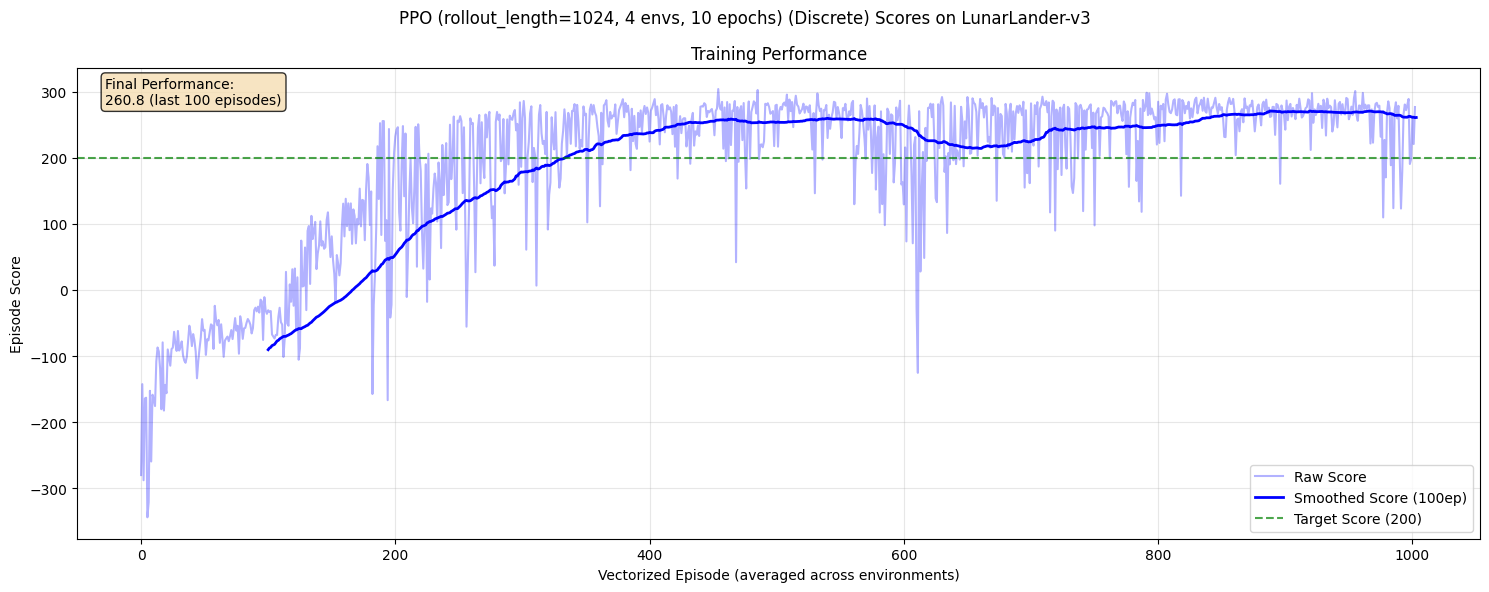

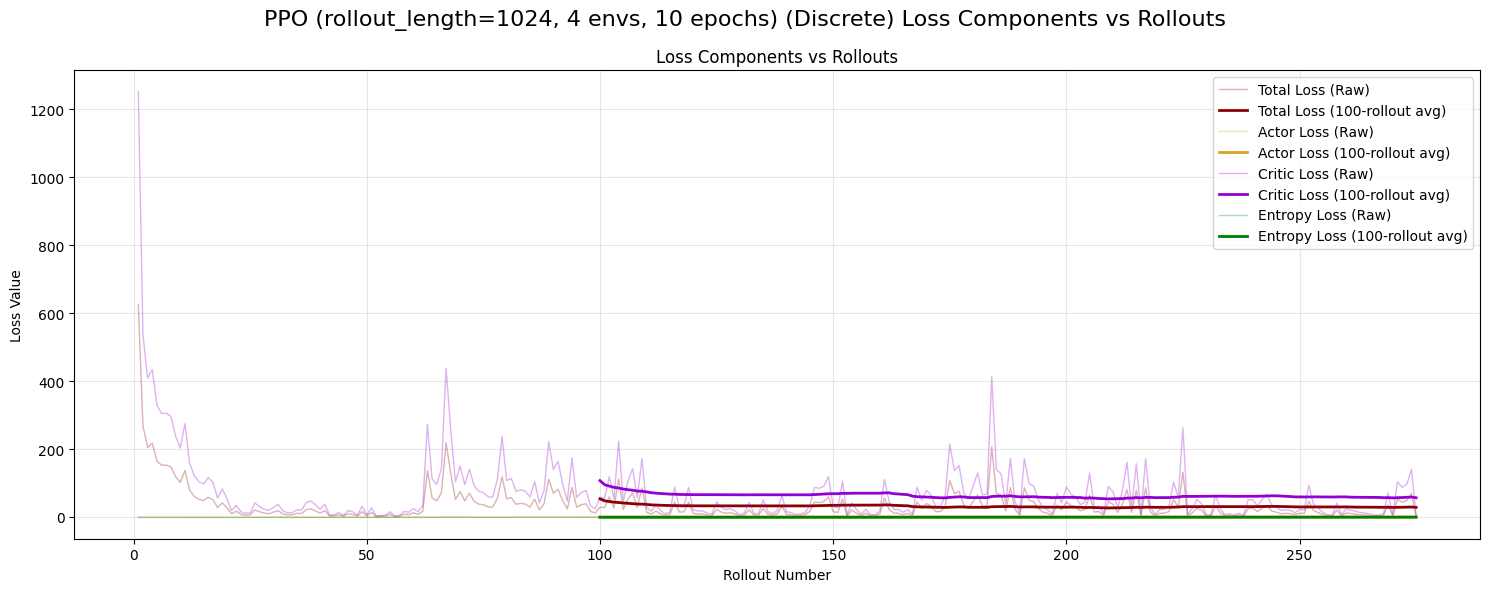

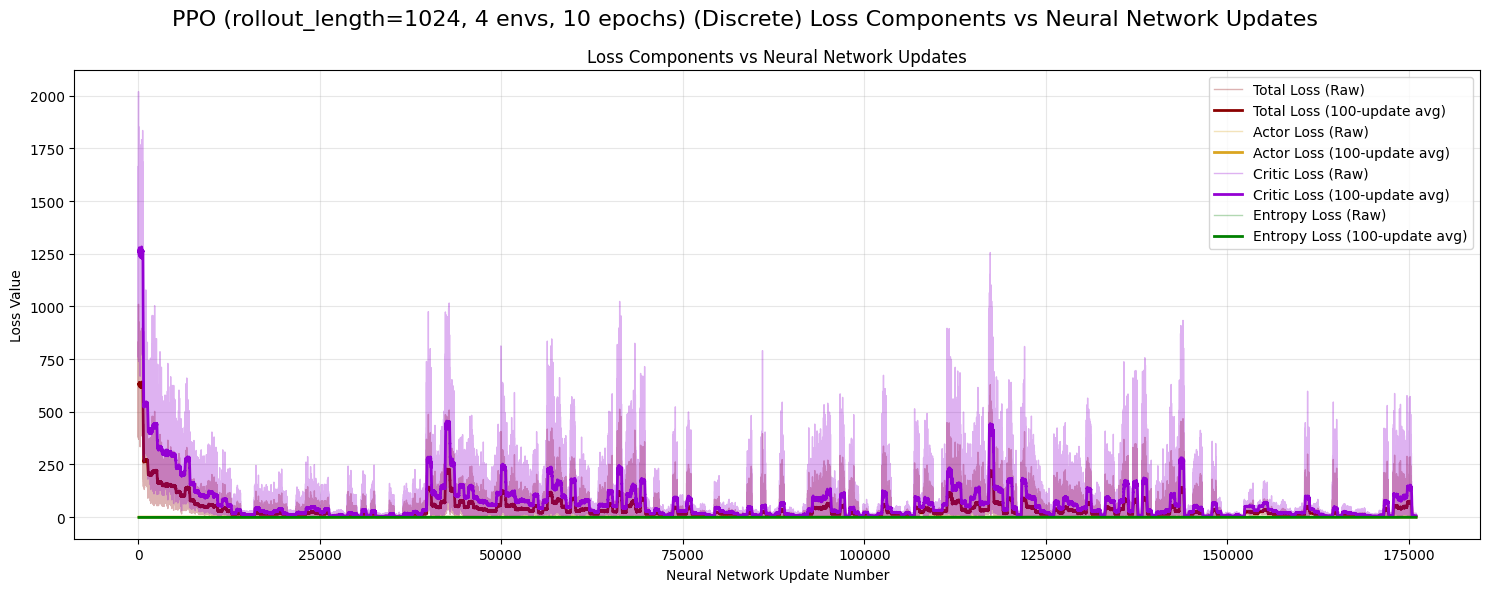

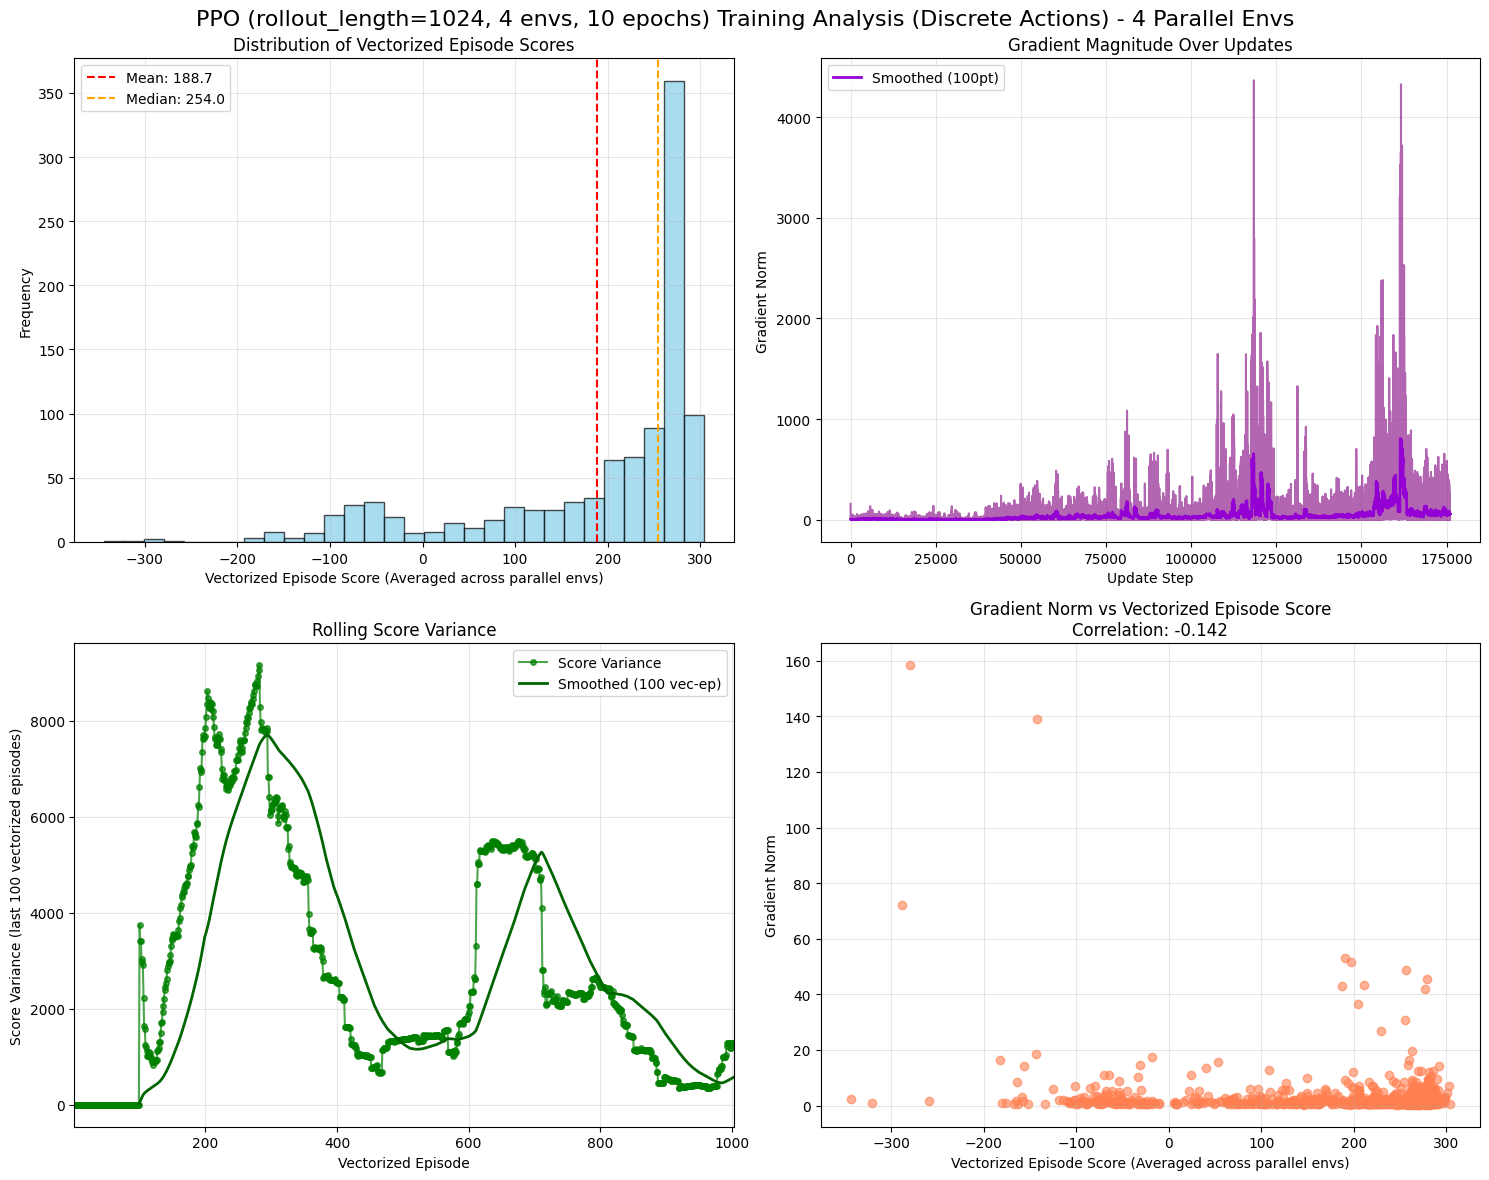

In [5]:
# Plot results for discrete PPO using rollout-based plotting
import importlib
import rl_utils.visualization
importlib.reload(rl_utils.visualization)
from rl_utils.visualization import plot_rollout_based_training_results, plot_vectorized_variance_analysis

plot_rollout_based_training_results(
    discrete_ppo_scores, 
    discrete_ppo_agent.loss_history,
    discrete_ppo_agent.rollout_history,
    discrete_ppo_agent.neural_net_update_history,
    CONFIG, 
    "Discrete", 
    algorithm_name=f"PPO (rollout_length={CONFIG['rollout_length']}, {CONFIG['num_envs']} envs, {CONFIG['epochs']} epochs)",
    per_update_losses=discrete_ppo_agent.per_update_losses
)

# Show variance analysis
plot_vectorized_variance_analysis(
    discrete_ppo_agent, 
    discrete_ppo_scores, 
    "Discrete", 
    CONFIG, 
    algorithm_name=f"PPO (rollout_length={CONFIG['rollout_length']}, {CONFIG['num_envs']} envs, {CONFIG['epochs']} epochs)"
)

# Show advantage normalization statistics
# variance_stats = discrete_ppo_agent.get_variance_stats();

In [6]:
# --- CONTINUOUS ACTION SPACE: PPO ---
print("Starting PPO training with CONTINUOUS actions...")

continuous_ppo_scores, continuous_ppo_losses, continuous_ppo_agent = train_ppo(
    is_continuous=True, 
    config=CONFIG
)


📹 Displaying 9 training videos (episodes: [110, 221, 332, 443, 554, 665, 776, 887, 998]):


📹 9 training videos available in videos/ppo_continuous


VecEp  995 | Score:  277.3 | AvgScore(100):  266.5 | Rollouts:  317 | NNUpdates: 202880 | ActorLoss:  0.0010 | CriticLoss: 15.1655 | KL: 0.0233 | PClip%: 21.1 | VClip%: 49.6 | : 100%|█████████▉| 995/1000 [20:35<00:06,  1.24s/vec-episode]


Continuous training completed in 1235.8 seconds!


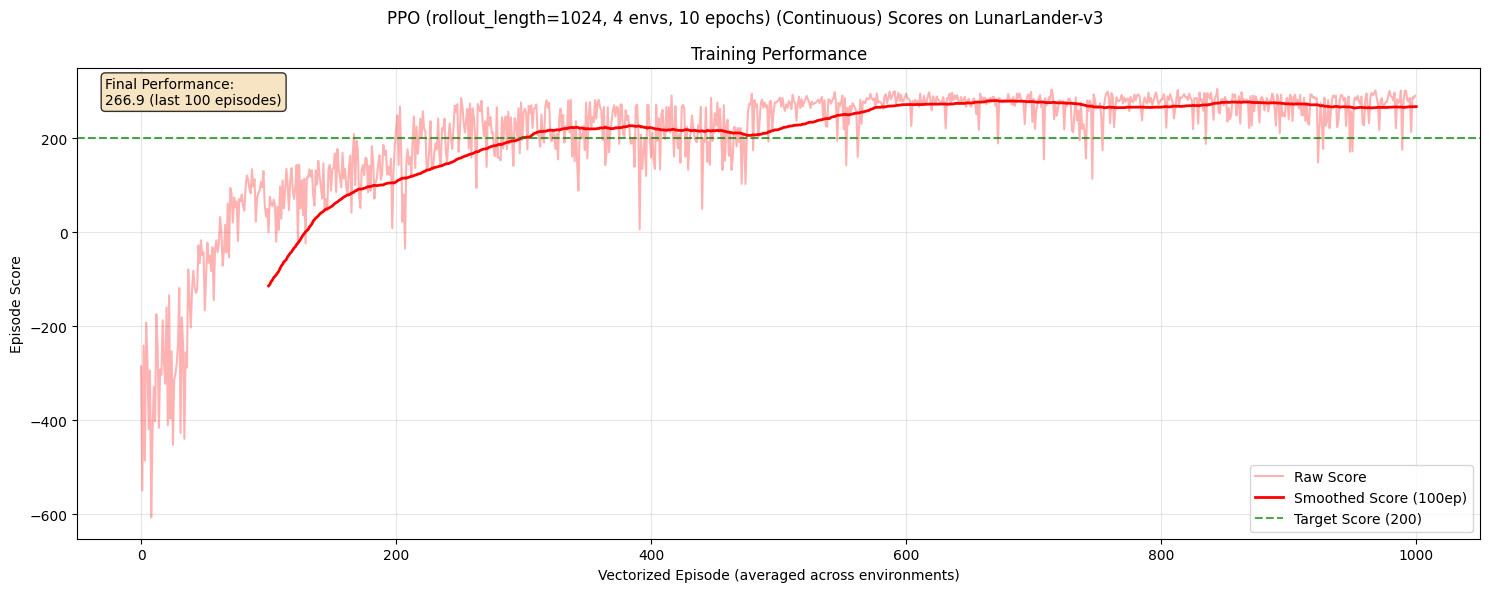

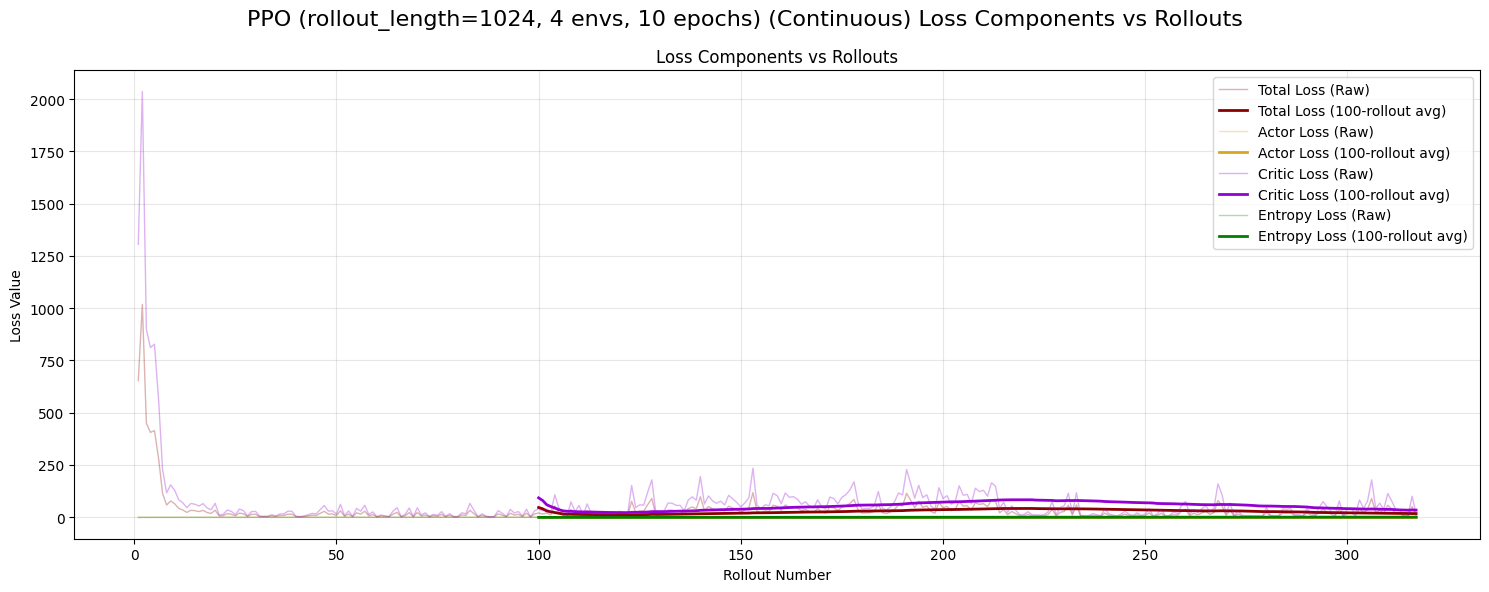

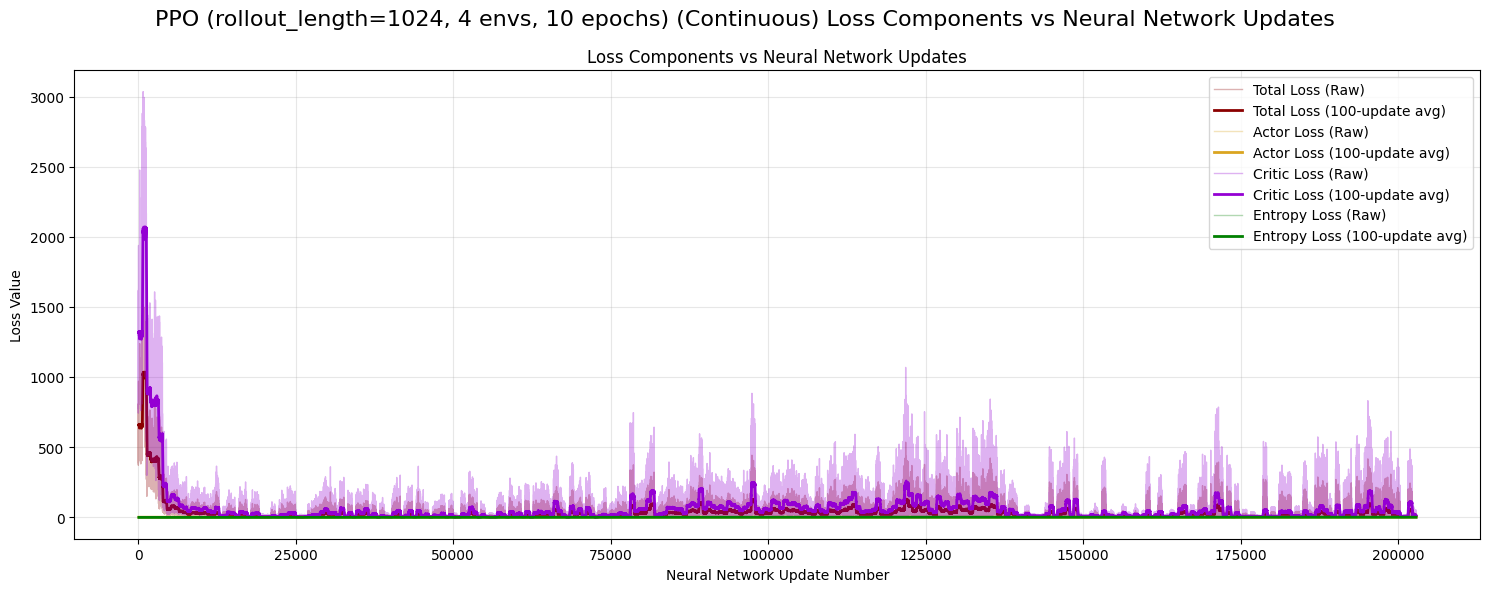

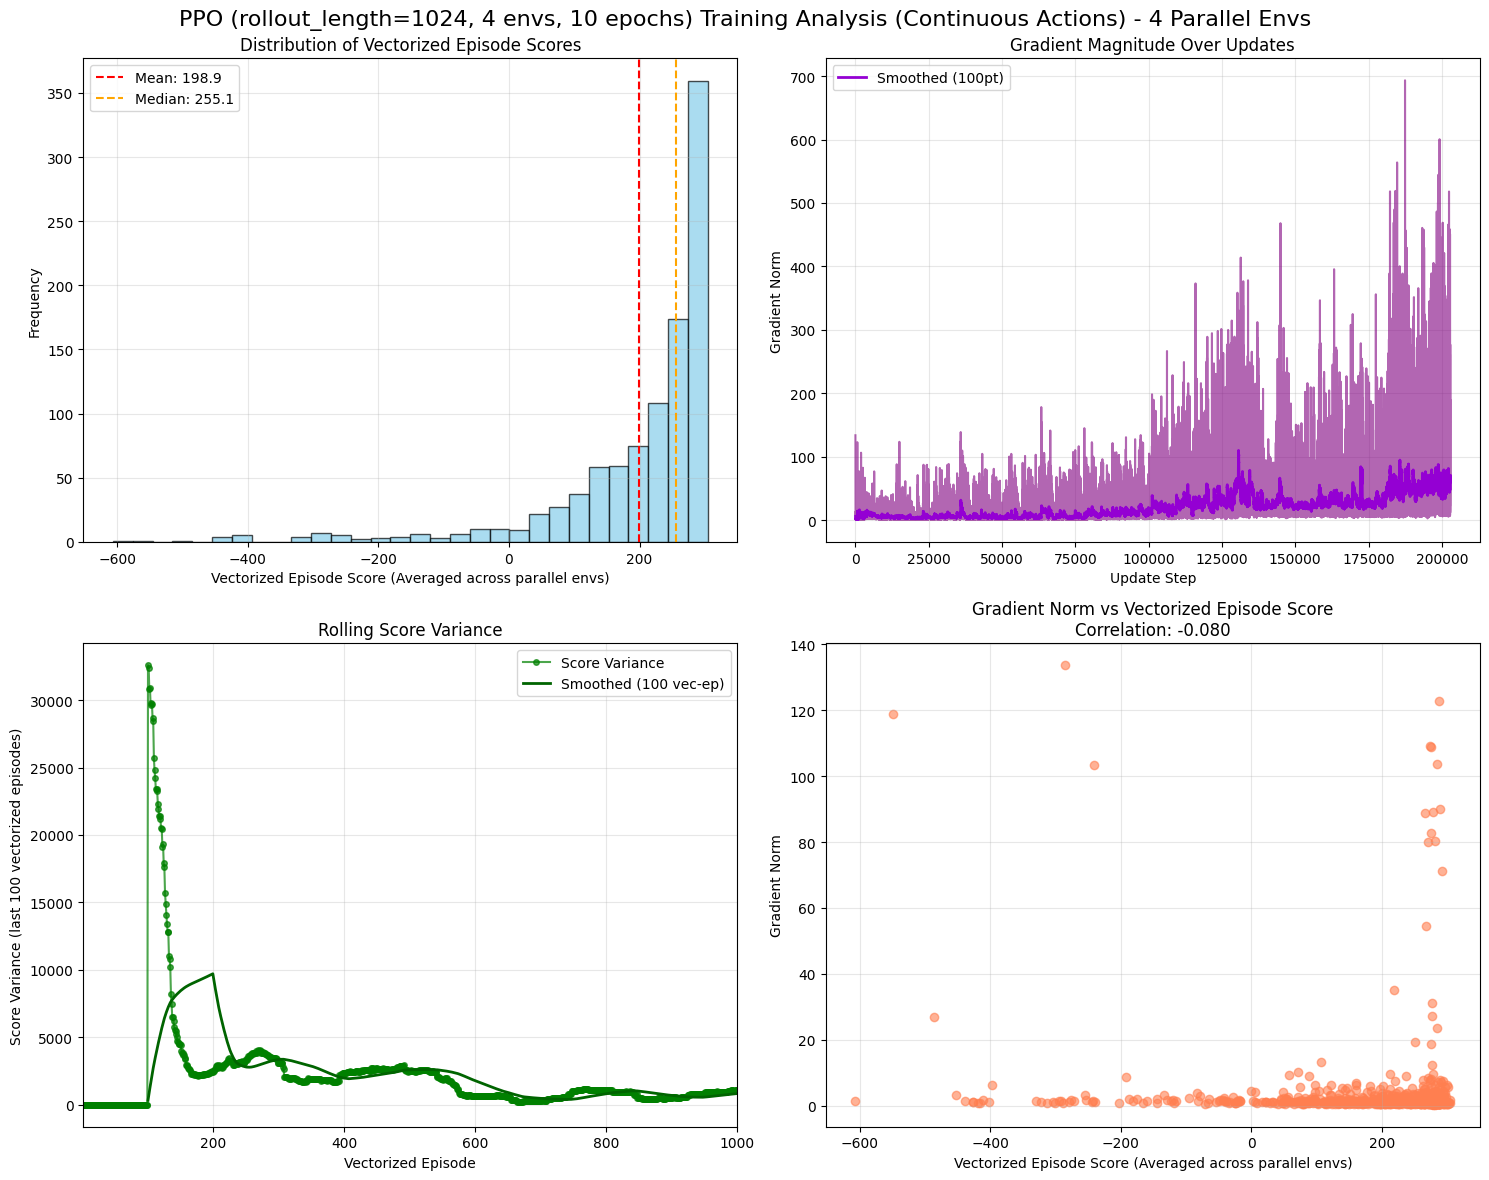

In [7]:
# Plot results for continuous PPO using rollout-based plotting
plot_rollout_based_training_results(
    continuous_ppo_scores, 
    continuous_ppo_agent.loss_history,
    continuous_ppo_agent.rollout_history,
    continuous_ppo_agent.neural_net_update_history,
    CONFIG, 
    "Continuous", 
    algorithm_name=f"PPO (rollout_length={CONFIG['rollout_length']}, {CONFIG['num_envs']} envs, {CONFIG['epochs']} epochs)",
    per_update_losses=continuous_ppo_agent.per_update_losses
)

# Show variance analysis
plot_vectorized_variance_analysis(
    continuous_ppo_agent, 
    continuous_ppo_scores, 
    "Continuous", 
    CONFIG, 
    algorithm_name=f"PPO (rollout_length={CONFIG['rollout_length']}, {CONFIG['num_envs']} envs, {CONFIG['epochs']} epochs)"
)

# Show advantage normalization statistics
variance_stats = continuous_ppo_agent.get_variance_stats()

# Training completion message
final_window_size = min(CONFIG["window_length"], len(continuous_ppo_scores))
final_avg = np.mean(continuous_ppo_scores[-final_window_size:]) if final_window_size > 0 else 0.0


COMPREHENSIVE ANALYSIS: PPO Performance and Modern RL Benefits

📊 FINAL PERFORMANCE COMPARISON (last 100 vectorized episodes):
Method               Final Score  Score Std  Grad Std   Rollouts  NNUpdates NN/Roll KL Div     Policy Clip % Value Clip % Grad CV  Score CV  Parameters  
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Discrete PPO         260.8        35.9       57.2061    275       176000    640.0   0.017236   14.2         62.3        1.038    0.138     9,445       
Continuous PPO       266.9        32.9       72.1048    317       202880    640.0   0.020153   18.2         51.5        1.038    0.123     9,381       

📈 PPO-SPECIFIC ANALYSIS:
Discrete PPO:
  Score variance (last 100 vectorized episodes): 1291.4
  Parallel environments: 4
  Rollout length: 1024 steps per environment
  Epochs per update: 10
  Minibatch size: 64
  Total rollouts: 275
  T

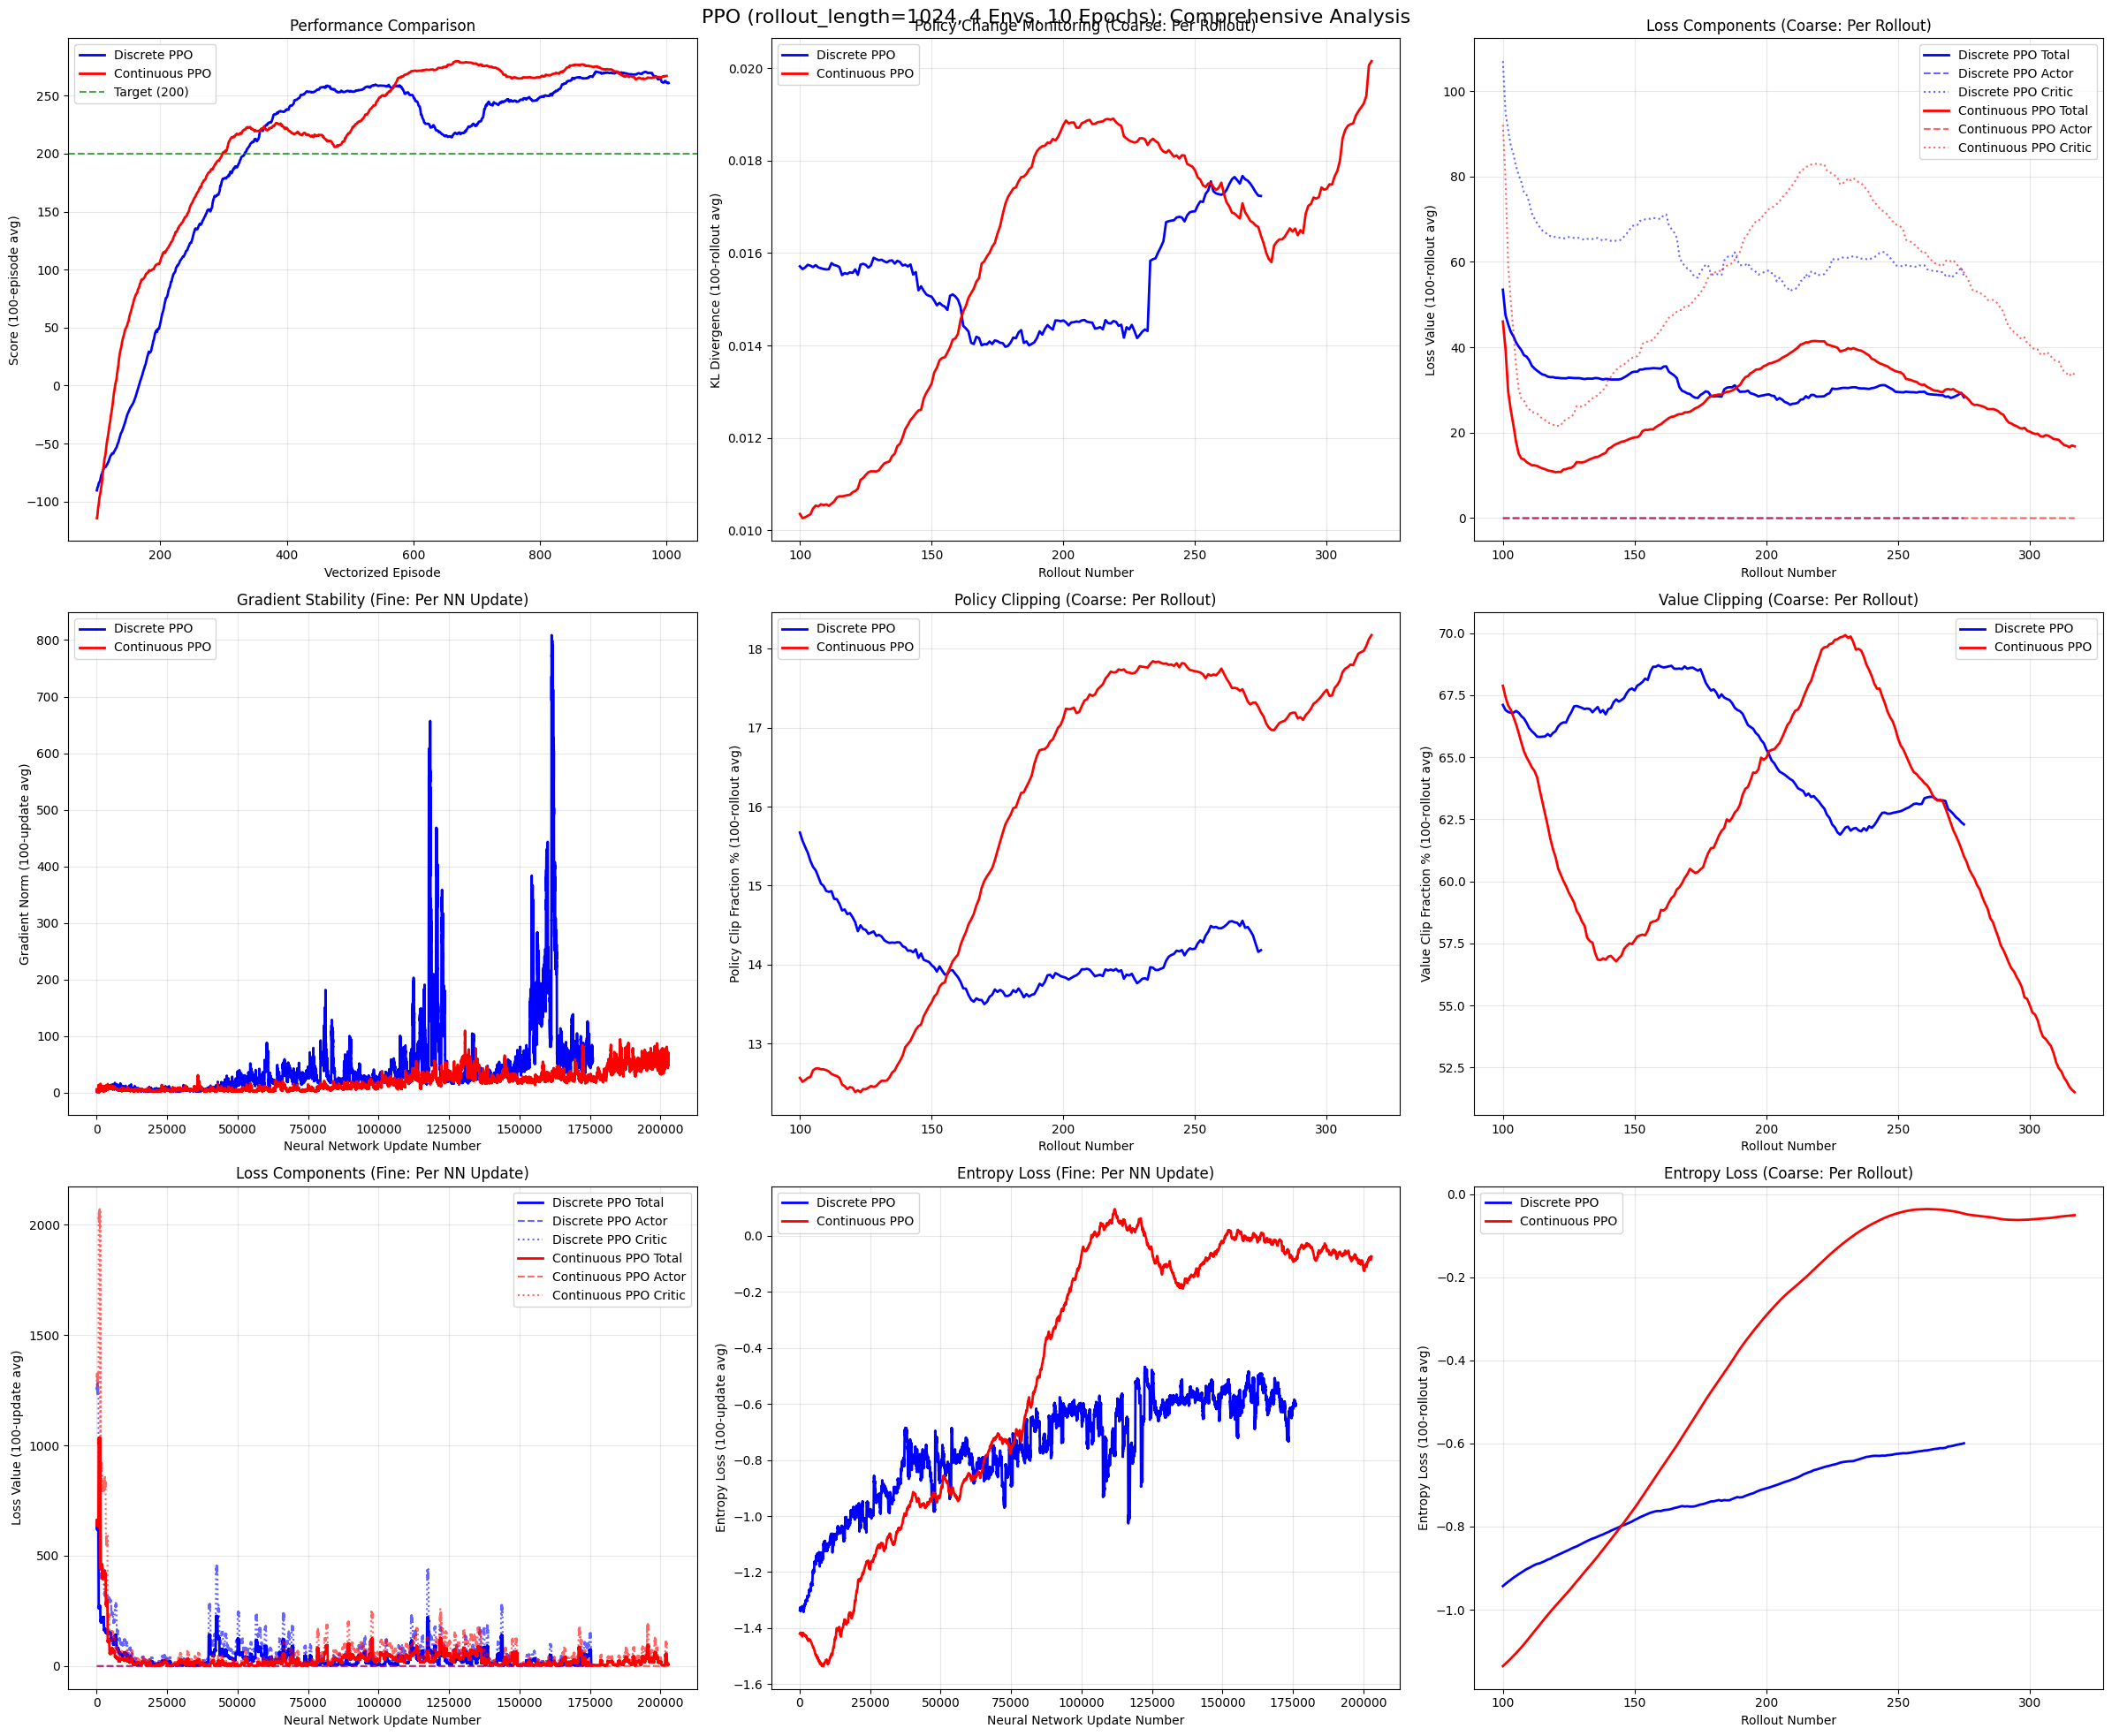

In [8]:
# --- COMPREHENSIVE ANALYSIS: PPO Performance and Modern RL Benefits ---
import matplotlib.pyplot as plt
from rl_utils.visualization import get_moving_average

print(f"\n{'='*80}")
print(f"COMPREHENSIVE ANALYSIS: PPO Performance and Modern RL Benefits")
print(f"{'='*80}")

# Collect experiment results
experiments = [
    ("Discrete PPO", discrete_ppo_scores, discrete_ppo_agent),
    ("Continuous PPO", continuous_ppo_scores, continuous_ppo_agent),
]

print(f"\n📊 FINAL PERFORMANCE COMPARISON (last {CONFIG['window_length']} vectorized episodes):")
print(f"{'Method':<20} {'Final Score':<12} {'Score Std':<10} {'Grad Std':<10} {'Rollouts':<9} {'NNUpdates':<9} {'NN/Roll':<7} {'KL Div':<10} {'Policy Clip %':<12} {'Value Clip %':<11} {'Grad CV':<8} {'Score CV':<9} {'Parameters':<12}")
print("-" * 175)

for name, scores, agent in experiments:
    final_window_size = min(CONFIG["window_length"], len(scores))
    final_score = np.mean(scores[-final_window_size:]) if final_window_size > 0 else 0.0
    
    stats = agent.get_variance_stats()
    rollouts = getattr(agent, 'rollout_count', 0)
    nn_updates = getattr(agent, 'neural_net_update_count', 0)
    nn_per_rollout = nn_updates / max(1, rollouts)
    param_count = agent.network.get_param_count()
    
    kl_div = stats.get('kl_div_mean', 0.0)
    policy_clip_frac = stats.get('policy_clip_fraction_mean', 0.0) * 100
    value_clip_frac = stats.get('value_clip_fraction_mean', 0.0) * 100

    print(f"{name:<20} {final_score:<12.1f} {stats['score_std']:<10.1f} {stats['gradient_norm_std']:<10.4f} {rollouts:<9} {nn_updates:<9} {nn_per_rollout:<7.1f} {kl_div:<10.6f} {policy_clip_frac:<12.1f} {value_clip_frac:<11.1f} {stats['gradient_cv']:<8.3f} {stats['score_cv']:<9.3f} {param_count:<12,}")

print(f"\n📈 PPO-SPECIFIC ANALYSIS:")
for name, scores, agent in experiments:
    stats = agent.get_variance_stats()
    recent_score_var = stats.get('recent_score_variance', 0.0)
    
    print(f"{name}:")
    print(f"  Score variance (last {CONFIG['window_length']} vectorized episodes): {recent_score_var:.1f}")
    print(f"  Parallel environments: {CONFIG['num_envs']}")
    print(f"  Rollout length: {CONFIG['rollout_length']} steps per environment")
    print(f"  Epochs per update: {CONFIG['epochs']}")
    print(f"  Minibatch size: {CONFIG['minibatch_size']}")
    print(f"  Total rollouts: {getattr(agent, 'rollout_count', 0)}")
    print(f"  Total neural network updates: {getattr(agent, 'neural_net_update_count', 0)}")
    print(f"  Neural network updates per rollout: {getattr(agent, 'neural_net_update_count', 0) / max(1, getattr(agent, 'rollout_count', 1)):.1f}")
    print(f"  Average KL divergence: {stats['kl_div_mean']:.6f}")
    print(f"  Average policy clip fraction: {stats['policy_clip_fraction_mean']*100:.1f}%")
    print(f"  Average value clip fraction: {stats['value_clip_fraction_mean']*100:.1f}%")

# Create PPO-specific analysis plots
# Create a larger figure with 9 subplots (3x3) to show both rollout and NN update perspectives
fig = plt.figure(figsize=(24, 20))

# Create subplots manually for better control
ax1 = plt.subplot(3, 3, 1)  # Scores vs Episodes
ax2 = plt.subplot(3, 3, 2)  # KL Divergence vs Rollouts (coarse)
ax3 = plt.subplot(3, 3, 3)  # Loss Components vs Rollouts (coarse)
ax4 = plt.subplot(3, 3, 4)  # Gradient Norms vs NN Updates (fine)
ax5 = plt.subplot(3, 3, 5)  # Policy Clipping vs Rollouts (coarse)
ax6 = plt.subplot(3, 3, 6)  # Value Clipping vs Rollouts (coarse)
ax7 = plt.subplot(3, 3, 7)  # Loss Components vs NN Updates (fine)
ax8 = plt.subplot(3, 3, 8)  # Per-Update Entropy Loss vs NN Updates (fine)
ax9 = plt.subplot(3, 3, 9)  # Entropy Loss vs Rollouts (coarse)

fig.suptitle(f'PPO (rollout_length={CONFIG["rollout_length"]}, {CONFIG["num_envs"]} Envs, {CONFIG["epochs"]} Epochs): Comprehensive Analysis', fontsize=16)

colors = ['blue', 'red']
smoothing_window = CONFIG["window_length"]

# 1. Performance comparison
for i, (name, scores, agent) in enumerate(experiments):
    if len(scores) >= smoothing_window:
        smoothed, offset = get_moving_average(scores, window=smoothing_window)
        episodes = range(offset + 1, offset + 1 + len(smoothed))
        ax1.plot(episodes, smoothed, label=name, color=colors[i], linewidth=2)

ax1.axhline(y=CONFIG["target_score"], color='g', linestyle='--', label=f'Target ({CONFIG["target_score"]})', alpha=0.7)
ax1.set_xlabel('Vectorized Episode')
ax1.set_ylabel(f'Score ({smoothing_window}-episode avg)')
ax1.set_title('Performance Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. KL Divergence tracking (PPO-specific, coarse-grained per rollout)
for i, (name, scores, agent) in enumerate(experiments):
    if len(agent.kl_divergence_history) >= smoothing_window:
        smoothed, offset = get_moving_average(agent.kl_divergence_history, window=smoothing_window)
        rollout_steps = range(offset + 1, offset + 1 + len(smoothed))
        ax2.plot(rollout_steps, smoothed, label=name, color=colors[i], linewidth=2)

ax2.set_xlabel('Rollout Number')
ax2.set_ylabel(f'KL Divergence ({smoothing_window}-rollout avg)')
ax2.set_title('Policy Change Monitoring (Coarse: Per Rollout)')
if CONFIG.get("target_kl"):
    ax2.axhline(y=CONFIG["target_kl"], color='r', linestyle='--', label=f'Target KL ({CONFIG["target_kl"]})', alpha=0.7)
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Loss components over rollouts (coarse-grained)
for i, (name, scores, agent) in enumerate(experiments):
    if len(agent.loss_history["total_loss"]) >= smoothing_window:
        # Plot total loss
        smoothed_total, offset = get_moving_average(agent.loss_history["total_loss"], window=smoothing_window)
        rollout_steps = range(offset + 1, offset + 1 + len(smoothed_total))
        ax3.plot(rollout_steps, smoothed_total, label=f'{name} Total', color=colors[i], linewidth=2)
        
        # Plot actor and critic losses with transparency
        if len(agent.loss_history["actor_loss"]) >= smoothing_window:
            smoothed_actor, _ = get_moving_average(agent.loss_history["actor_loss"], window=smoothing_window)
            ax3.plot(rollout_steps, smoothed_actor, label=f'{name} Actor', color=colors[i], alpha=0.6, linestyle='--')
        
        if len(agent.loss_history["critic_loss"]) >= smoothing_window:
            smoothed_critic, _ = get_moving_average(agent.loss_history["critic_loss"], window=smoothing_window)
            ax3.plot(rollout_steps, smoothed_critic, label=f'{name} Critic', color=colors[i], alpha=0.6, linestyle=':')

ax3.set_xlabel('Rollout Number')
ax3.set_ylabel(f'Loss Value ({smoothing_window}-rollout avg)')
ax3.set_title('Loss Components (Coarse: Per Rollout)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Gradient Norms vs Neural Network Updates (fine-grained)
for i, (name, scores, agent) in enumerate(experiments):
    if len(agent.gradient_norms) >= smoothing_window:
        smoothed, offset = get_moving_average(agent.gradient_norms, window=smoothing_window)
        nn_update_steps = range(offset + 1, offset + 1 + len(smoothed))
        ax4.plot(nn_update_steps, smoothed, label=name, color=colors[i], linewidth=2)

ax4.set_xlabel('Neural Network Update Number')
ax4.set_ylabel(f'Gradient Norm ({smoothing_window}-update avg)')
ax4.set_title('Gradient Stability (Fine: Per NN Update)')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Policy clip fraction over time (PPO-specific, coarse-grained per rollout)
for i, (name, scores, agent) in enumerate(experiments):
    if len(agent.policy_clip_fraction_history) >= smoothing_window:
        smoothed, offset = get_moving_average(agent.policy_clip_fraction_history, window=smoothing_window)
        rollout_steps = range(offset + 1, offset + 1 + len(smoothed))
        ax5.plot(rollout_steps, [x*100 for x in smoothed], label=name, color=colors[i], linewidth=2)

ax5.set_xlabel('Rollout Number')
ax5.set_ylabel(f'Policy Clip Fraction % ({smoothing_window}-rollout avg)')
ax5.set_title('Policy Clipping (Coarse: Per Rollout)')
# ax5.axhline(y=CONFIG["clip_epsilon"]*100, color='g', linestyle='--', 
#            label=f'Policy Clip Threshold ({CONFIG["clip_epsilon"]*100:.1f}%)', alpha=0.7)
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Value clip fraction over time (PPO-specific, coarse-grained per rollout)
for i, (name, scores, agent) in enumerate(experiments):
    if len(agent.value_clip_fraction_history) >= smoothing_window:
        smoothed, offset = get_moving_average(agent.value_clip_fraction_history, window=smoothing_window)
        rollout_steps = range(offset + 1, offset + 1 + len(smoothed))
        ax6.plot(rollout_steps, [x*100 for x in smoothed], label=name, color=colors[i], linewidth=2)

ax6.set_xlabel('Rollout Number')
ax6.set_ylabel(f'Value Clip Fraction % ({smoothing_window}-rollout avg)')
ax6.set_title('Value Clipping (Coarse: Per Rollout)')
# ax6.axhline(y=CONFIG["value_clip_epsilon"]*100, color='r', linestyle='--', 
#            label=f'Value Clip Threshold ({CONFIG["value_clip_epsilon"]*100:.1f}%)', alpha=0.7)
ax6.legend()
ax6.grid(True, alpha=0.3)

# 7. Loss Components vs Neural Network Updates (fine-grained using per_update_losses)
for i, (name, scores, agent) in enumerate(experiments):
    if len(agent.per_update_losses["total_loss"]) >= smoothing_window:
        # Plot total loss (fine-grained)
        smoothed_total, offset = get_moving_average(agent.per_update_losses["total_loss"], window=smoothing_window)
        nn_update_steps = range(offset + 1, offset + 1 + len(smoothed_total))
        ax7.plot(nn_update_steps, smoothed_total, label=f'{name} Total', color=colors[i], linewidth=2)
        
        # Plot actor and critic losses with transparency (fine-grained)
        if len(agent.per_update_losses["actor_loss"]) >= smoothing_window:
            smoothed_actor, _ = get_moving_average(agent.per_update_losses["actor_loss"], window=smoothing_window)
            ax7.plot(nn_update_steps, smoothed_actor, label=f'{name} Actor', color=colors[i], alpha=0.6, linestyle='--')
        
        if len(agent.per_update_losses["critic_loss"]) >= smoothing_window:
            smoothed_critic, _ = get_moving_average(agent.per_update_losses["critic_loss"], window=smoothing_window)
            ax7.plot(nn_update_steps, smoothed_critic, label=f'{name} Critic', color=colors[i], alpha=0.6, linestyle=':')

ax7.set_xlabel('Neural Network Update Number')
ax7.set_ylabel(f'Loss Value ({smoothing_window}-update avg)')
ax7.set_title('Loss Components (Fine: Per NN Update)')
ax7.legend()
ax7.grid(True, alpha=0.3)

# 8. Per-Update Entropy Loss vs Neural Network Updates (fine-grained)
for i, (name, scores, agent) in enumerate(experiments):
    if len(agent.per_update_losses["entropy_loss"]) >= smoothing_window:
        smoothed, offset = get_moving_average(agent.per_update_losses["entropy_loss"], window=smoothing_window)
        nn_update_steps = range(offset + 1, offset + 1 + len(smoothed))
        ax8.plot(nn_update_steps, smoothed, label=name, color=colors[i], linewidth=2)

ax8.set_xlabel('Neural Network Update Number')
ax8.set_ylabel(f'Entropy Loss ({smoothing_window}-update avg)')
ax8.set_title('Entropy Loss (Fine: Per NN Update)')
ax8.legend()
ax8.grid(True, alpha=0.3)

# 9. Entropy Loss vs Rollouts (coarse-grained)
for i, (name, scores, agent) in enumerate(experiments):
    if len(agent.loss_history["entropy_loss"]) >= smoothing_window:
        smoothed, offset = get_moving_average(agent.loss_history["entropy_loss"], window=smoothing_window)
        rollout_steps = range(offset + 1, offset + 1 + len(smoothed))
        ax9.plot(rollout_steps, smoothed, label=name, color=colors[i], linewidth=2)

ax9.set_xlabel('Rollout Number')
ax9.set_ylabel(f'Entropy Loss ({smoothing_window}-rollout avg)')
ax9.set_title('Entropy Loss (Coarse: Per Rollout)')
ax9.legend()
ax9.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Learning Outcomes and Analysis

### 🔍 Understanding RL Losses vs Performance

PPO introduces **additional loss components** that make interpretation even more complex:

**Clipped Policy Loss**: `min(ratio * advantages, clipped_ratio * advantages)`
- **Clipping effect**: Loss artificially capped when policy changes too much
- **Misleading stability**: Low loss might mean clipping is active (preventing learning), not good performance

**Value Loss**: `max(unclipped_v_loss, clipped_v_loss)`
- **Double clipping**: Value function updates also clipped for stability
- **Conservative updates**: Low loss doesn't indicate accurate value estimates, just cautious updates

**Entropy Loss**: `-entropy.mean()`
- **Exploration trade-off**: Decreasing loss means less exploration (can be good or bad)
- **Annealing effect**: Natural decrease over training regardless of performance

**PPO-Specific Paradox**: 
- **Trust region success**: PPO prevents destructive updates, keeping losses low even during poor performance phases
- **Multiple epochs**: Same data used for multiple updates, creating artificially smooth loss curves
- **KL monitoring**: Algorithm health measured by KL divergence, not loss values

**What matters for PPO**: Episode scores, clipping fractions (indicates trust region activation), KL divergence (policy change rate), and score stability.

### 🎯 Performance Summary: The Crown Achievement

PPO delivers our most successful results across both action spaces:

**Discrete PPO**: Final Score = 260.8 🌟 (Excellent! Well above target 200)  
**Continuous PPO**: Final Score = 266.9 🌟 (Excellent! Well above target 200)

**Historic Achievement**: PPO is our **first algorithm to achieve reliable success in both action spaces**.

### 📊 Stability Revolution

#### Score Stability: Best-in-Class
**Discrete PPO**: Score CV = 0.138 🟢 (Very stable performance)  
**Continuous PPO**: Score CV = 0.123 🟢 (Very stable performance)

**Breakthrough**: PPO achieves the most stable performance we've seen, with both agents showing very consistent episode outcomes.

#### Gradient Stability: Finally Controlled
**Discrete PPO**: Gradient CV = 1.038 🟠 (Moderate stability)  
**Continuous PPO**: Gradient CV = 1.038 🟠 (Moderate stability)

**Key Achievement**: PPO's clipping mechanisms successfully control gradient instability that plagued TD and A2C methods.

### 🎯 PPO's Advanced Features in Action

**KL Divergence Monitoring**:
- Discrete: 0.0172 (healthy policy change rate)
- Continuous: 0.0202 (similar, stable policy evolution)

**Policy Clipping Effectiveness**:
- Discrete: 14.2% of updates clipped (moderate trust region activation)
- Continuous: 18.2% of updates clipped (slightly higher, but controlled)

**Value Function Clipping**:
- Discrete: 62.3% of value updates clipped (moderate value stabilization)
- Continuous: 51.5% of value updates clipped (moderate value stabilization)

### 📈 Learning Efficiency Analysis

**Neural Network Updates**: 
- Discrete: 176,000 total updates (640 per rollout)
- Continuous: 202,880 total updates (640 per rollout)

**Innovation**: PPO's multiple epochs per rollout (10 epochs × 64 minibatches = 640 updates per rollout) maximizes data utilization while maintaining stability through clipping.

### 🔍 PPO's Key Success Factors

1. **Trust Region Magic**: Clipped objectives prevent destructive policy updates while allowing steady improvement

2. **GAE Advantage Estimation**: Sophisticated advantage calculation balances bias and variance optimally

3. **Data Reuse**: Multiple epochs per rollout dramatically improve sample efficiency compared to single-use methods

4. **Robust Architecture**: Works excellently across both discrete and continuous action spaces

### 📊 Variance Reduction Success

**Score Variance**:
- Discrete: 1,291.4 (lowest we've achieved)
- Continuous: 1,079.4 (dramatically lower than all previous methods)

**Insight**: PPO's combination of parallel environments, trust regions, and sophisticated advantage estimation finally solves the variance problem that started with REINFORCE.

### 🏆 The Complete Journey

From REINFORCE's failure (scores around 0) to PPO's mastery (scores > 260), we've witnessed the evolution of modern RL:

1. **REINFORCE**: Established the variance problem
2. **Actor-Critic MC**: Introduced baselines for variance reduction  
3. **Actor-Critic TD**: Added bootstrapping for sample efficiency
4. **A2C**: Leveraged parallel environments for stability
5. **PPO**: Perfected the combination with trust regions and advanced estimation

**Final Verdict**: PPO represents the current state-of-the-art in on-policy RL, successfully balancing sample efficiency, stability, and performance across diverse action spaces. This doesn't mean RL is easy. RL is still very unstable compared to supervised learning